<a href="https://colab.research.google.com/github/fireHedgehog/music-intrument-OvA-model/blob/main/multi-spectrogram-experiment/validation_of_6_spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Validation

1. Load the prepared data for validation.
2. Extract the last 50 samples for each instrument family from each spectrogram type.
3. Combine these samples into a single validation dataset.
4. Map the true labels back to the NSynth dataset labels, excluding "synth_lead."
5. Perform validation and save the results.
6. Adapted Validation Code

In [1]:
import tensorflow as tf
import numpy as np
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import cv2  # Import OpenCV for resizing


Mount google drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Need to generate the polyphony samples



define the global vars

In [3]:
# Directory paths
base_dir = '/content/drive/My Drive/200-each-instrument/'
combined_save_dir = os.path.join(base_dir, 'all_combined_with_padding')
output_dir = '/content/drive/My Drive/output-multi-gram/'
models_dir = os.path.join(output_dir, 'models')
metrics_dir = os.path.join(output_dir, 'metrics')
test_results_dir = os.path.join(output_dir, 'test_results')

os.makedirs(test_results_dir, exist_ok=True)

load data


In [4]:
# Instrument families and their original NSynth labels
instrument_families = {
    'bass': 0,
    'brass': 1,
    'flute': 2,
    'guitar': 3,
    'keyboard': 4,
    'mallet': 5,
    'organ': 6,
    'reed': 7,
    'string': 8,
    #'synth_lead' : 9, missing from tensorflow dataset
    'vocal': 10
}

# Spectrogram types
spectrogram_types = ['stft', 'log_mel', 'mfcc', 'chroma', 'spectral_contrast', 'tonnetz', 'all_combined_with_padding']

# Load data function
def load_data(family, spectrogram_type=None):
    if spectrogram_type:
        if spectrogram_type != "all_combined_with_padding":
            file_path = os.path.join(base_dir, spectrogram_type, family, f'{family}_{spectrogram_type}.npy')
        else:
            file_path = os.path.join(combined_save_dir, f'{family}_combined.npy')
    else:
        file_path = os.path.join(base_dir, f'{family}.npy')
    return np.load(file_path)


load models

In [5]:
# Instrument families and their original NSynth labels
instrument_families = {
    'bass': 0,
    'brass': 1,
    'flute': 2,
    'guitar': 3,
    'keyboard': 4,
    'mallet': 5,
    'organ': 6,
    'reed': 7,
    'string': 8,
    #'synth_lead' : 9, missing from tensorflow dataset
    'vocal': 9  # Adjusted index to 9 since 'synth_lead' is missing
}

# Spectrogram types
spectrogram_types = ['stft', 'log_mel', 'mfcc', 'chroma', 'spectral_contrast', 'tonnetz', 'all_combined_with_padding']

# Load data function
def load_data(family, spectrogram_type=None):
    if spectrogram_type:
        if spectrogram_type != "all_combined_with_padding":
            file_path = os.path.join(base_dir, spectrogram_type, family, f'{family}_{spectrogram_type}.npy')
        else:
            file_path = os.path.join(combined_save_dir, f'{family}_combined.npy')
    else:
        file_path = os.path.join(base_dir, f'{family}.npy')
    return np.load(file_path)


# Load models function
def load_models(spectrogram_type):
    model_cache = {}
    for family in instrument_families:
        model_path = os.path.join(models_dir, spectrogram_type, f'{spectrogram_type}_{family}.h5')
        model_cache[family] = load_model(model_path)
    return model_cache

# Function to resize spectrograms
def resize_spectrogram(spectrogram, target_shape):
    return cv2.resize(spectrogram, target_shape, interpolation=cv2.INTER_CUBIC)


validation

In [ ]:
# Validation function
def validate_and_save_results(spectrogram_type, model_cache):
    x_val = []
    y_val = []

    for family, label in instrument_families.items():
        data_check = load_data(family, spectrogram_type)[:1] # check the first training sample size
        data = load_data(family, spectrogram_type)[-50:]  # Get the last 50 samples
        if data[0].shape != data_check[0].shape:
            # 6(spetrogram)+1(all_combined) * 10(instrument) = 70(senario) so need to debug if there is a mistake while we generate the data
            print(f"Resizing required for {spectrogram_type}, {family}, index: 0")
            print(f"Training shape: {data_check[0].shape}, Testing shape: {data[0].shape}")

            target_shape = data_check[0].shape
            resized_data = np.array([resize_spectrogram(s, target_shape) for s in data])

        else:
            resized_data = data
        x_val.append(resized_data)
        y_val.extend([label] * len(resized_data))

    x_val = np.concatenate(x_val, axis=0)
    y_val = np.array(y_val)

    x_val = np.expand_dims(x_val, axis=-1)

    y_pred = np.zeros((x_val.shape[0], len(instrument_families)))
    for family, label in instrument_families.items():
        y_pred[:, label] = model_cache[family].predict(x_val).flatten()

    y_pred_labels = np.argmax(y_pred, axis=1)

    true_label_path = os.path.join(test_results_dir, f'{spectrogram_type}_true_labels.txt')
    predicted_labels_path = os.path.join(test_results_dir, f'{spectrogram_type}_predicted_labels.txt')

    np.savetxt(true_label_path, y_val, fmt='%d')
    np.savetxt(predicted_labels_path, y_pred_labels, fmt='%d')

    print(f"True labels saved to: {true_label_path}")
    print(f"Predicted labels saved to: {predicted_labels_path}")

    print(f"\nClassification Report for {spectrogram_type}:")
    print(classification_report(y_val, y_pred_labels, target_names=list(instrument_families.keys())))

    conf_matrix = confusion_matrix(y_val, y_pred_labels)
    print(f"Confusion Matrix for {spectrogram_type}:\n{conf_matrix}")

In [ ]:
# Main validation loop for all spectrogram types
for spectrogram_type in spectrogram_types:
    model_cache = load_models(spectrogram_type)
    validate_and_save_results(spectrogram_type, model_cache)

print("Validation completed and results saved.")

16/16 [==============================] - 1s 43ms/step
True labels saved to: /content/drive/My Drive/output-multi-gram/test_results/all_combined_with_padding_true_labels.txt
Predicted labels saved to: /content/drive/My Drive/output-multi-gram/test_results/all_combined_with_padding_predicted_labels.txt

Classification Report for all_combined_with_padding:
              precision    recall  f1-score   support

        bass       0.23      0.32      0.27        50
       brass       0.41      0.86      0.56        50
       flute       0.62      0.74      0.67        50
      guitar       0.70      0.32      0.44        50
    keyboard       0.54      0.26      0.35        50
      mallet       0.38      0.56      0.46        50
       organ       0.83      0.88      0.85        50
        reed       0.52      0.32      0.40        50
      string       0.87      0.54      0.67        50
       vocal       0.75      0.48      0.59        50

    accuracy                           0.53     

plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.gridspec import GridSpec

# Directory paths
base_dir = '/content/drive/My Drive/200-each-instrument/'
output_dir = '/content/drive/My Drive/output-multi-gram/'
metrics_dir = os.path.join(output_dir, 'metrics')

# Instrument families and their original NSynth labels
instrument_families = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'vocal']

# Spectrogram types
spectrogram_types = ['stft', 'log_mel', 'mfcc', 'chroma', 'spectral_contrast', 'tonnetz', 'all_combined_with_padding']

# Function to read data from a text file
def read_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read().splitlines()
    return np.array(data, dtype=float)

def format_label(label):
    # Replace underscores with spaces
    label = label.replace('_', ' ')
    # Capitalize the first letter of each word
    formatted_label = label.title()
    return formatted_label

# Function to plot and save training curves for a specific instrument
def plot_training_curves(instrument):
    num_plots = len(spectrogram_types) * 2  # Two plots per spectrogram type (loss and accuracy)
    num_cols = 4  # Four plots per row
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig = plt.figure(figsize=(20, 4 * num_rows))
    fig.suptitle(f'Training Curves for {instrument.title()}', fontsize=16, y=1.00)
    gs = GridSpec(num_rows, num_cols, figure=fig)

    plot_index = 0

    for i, spectrogram_type in enumerate(spectrogram_types):
        loss_file = os.path.join(metrics_dir, spectrogram_type, f'{spectrogram_type}_{instrument}_loss_curve.txt')
        acc_file = os.path.join(metrics_dir, spectrogram_type, f'{spectrogram_type}_{instrument}_acc_curve.txt')

        if spectrogram_type == 'all_combined_with_padding':
            row, col = divmod(plot_index, num_cols)
            ax_loss = fig.add_subplot(gs[row, col:col+2])
            ax_acc = fig.add_subplot(gs[row, col+2:col+4])
            plot_index += 4  # Skip next 4 cells
        else:
            row, col = divmod(plot_index, num_cols)
            ax_loss = fig.add_subplot(gs[row, col])
            ax_acc = fig.add_subplot(gs[row, col + 1])
            plot_index += 2  # Skip next 2 cells

        if os.path.exists(loss_file) and os.path.exists(acc_file):
            loss_data = read_data(loss_file)
            acc_data = read_data(acc_file)

            ax_loss.plot(loss_data)
            ax_loss.set_title(f'{spectrogram_type} Loss Curve')
            ax_loss.set_xlabel('Epochs')
            ax_loss.set_ylabel('Loss')

            ax_acc.plot(acc_data)
            ax_acc.set_title(f'{spectrogram_type} Accuracy Curve')
            ax_acc.set_xlabel('Epochs')
            ax_acc.set_ylabel('Accuracy')
        else:
            ax_loss.text(0.5, 0.5, 'File Not Found', horizontalalignment='center', verticalalignment='center', transform=ax_loss.transAxes)
            ax_acc.text(0.5, 0.5, 'File Not Found', horizontalalignment='center', verticalalignment='center', transform=ax_acc.transAxes)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
    plt.subplots_adjust(top=0.95)  # Increase space above the subplots
    plt.savefig(os.path.join(metrics_dir, f'{instrument}_training_curves.png'))
    plt.show()

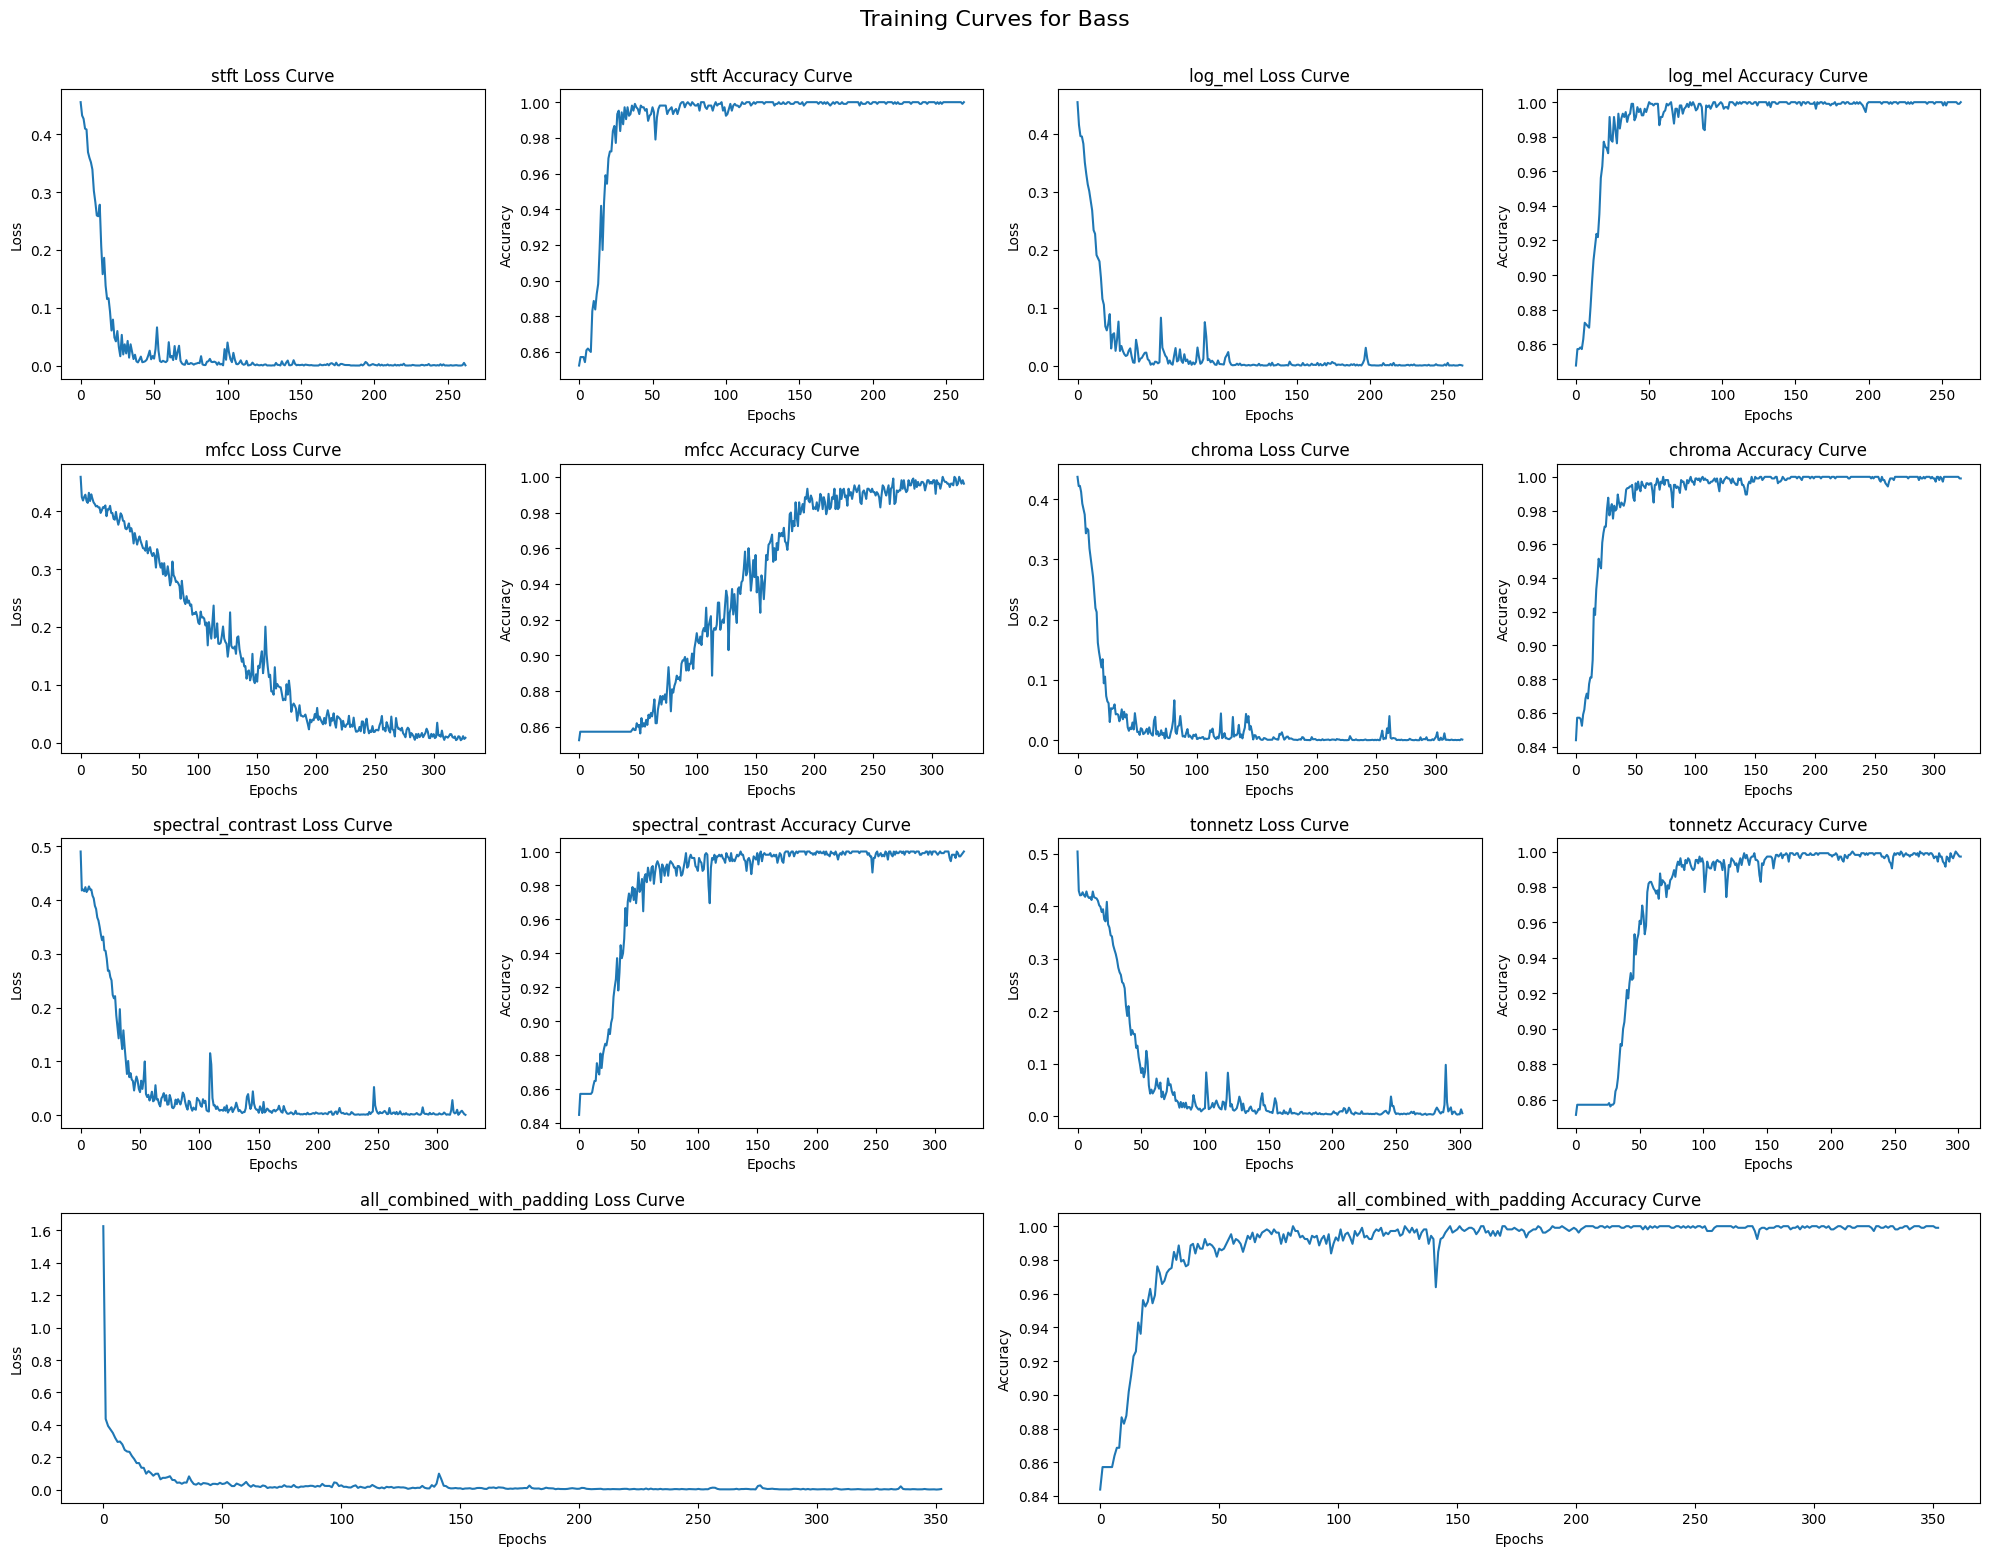

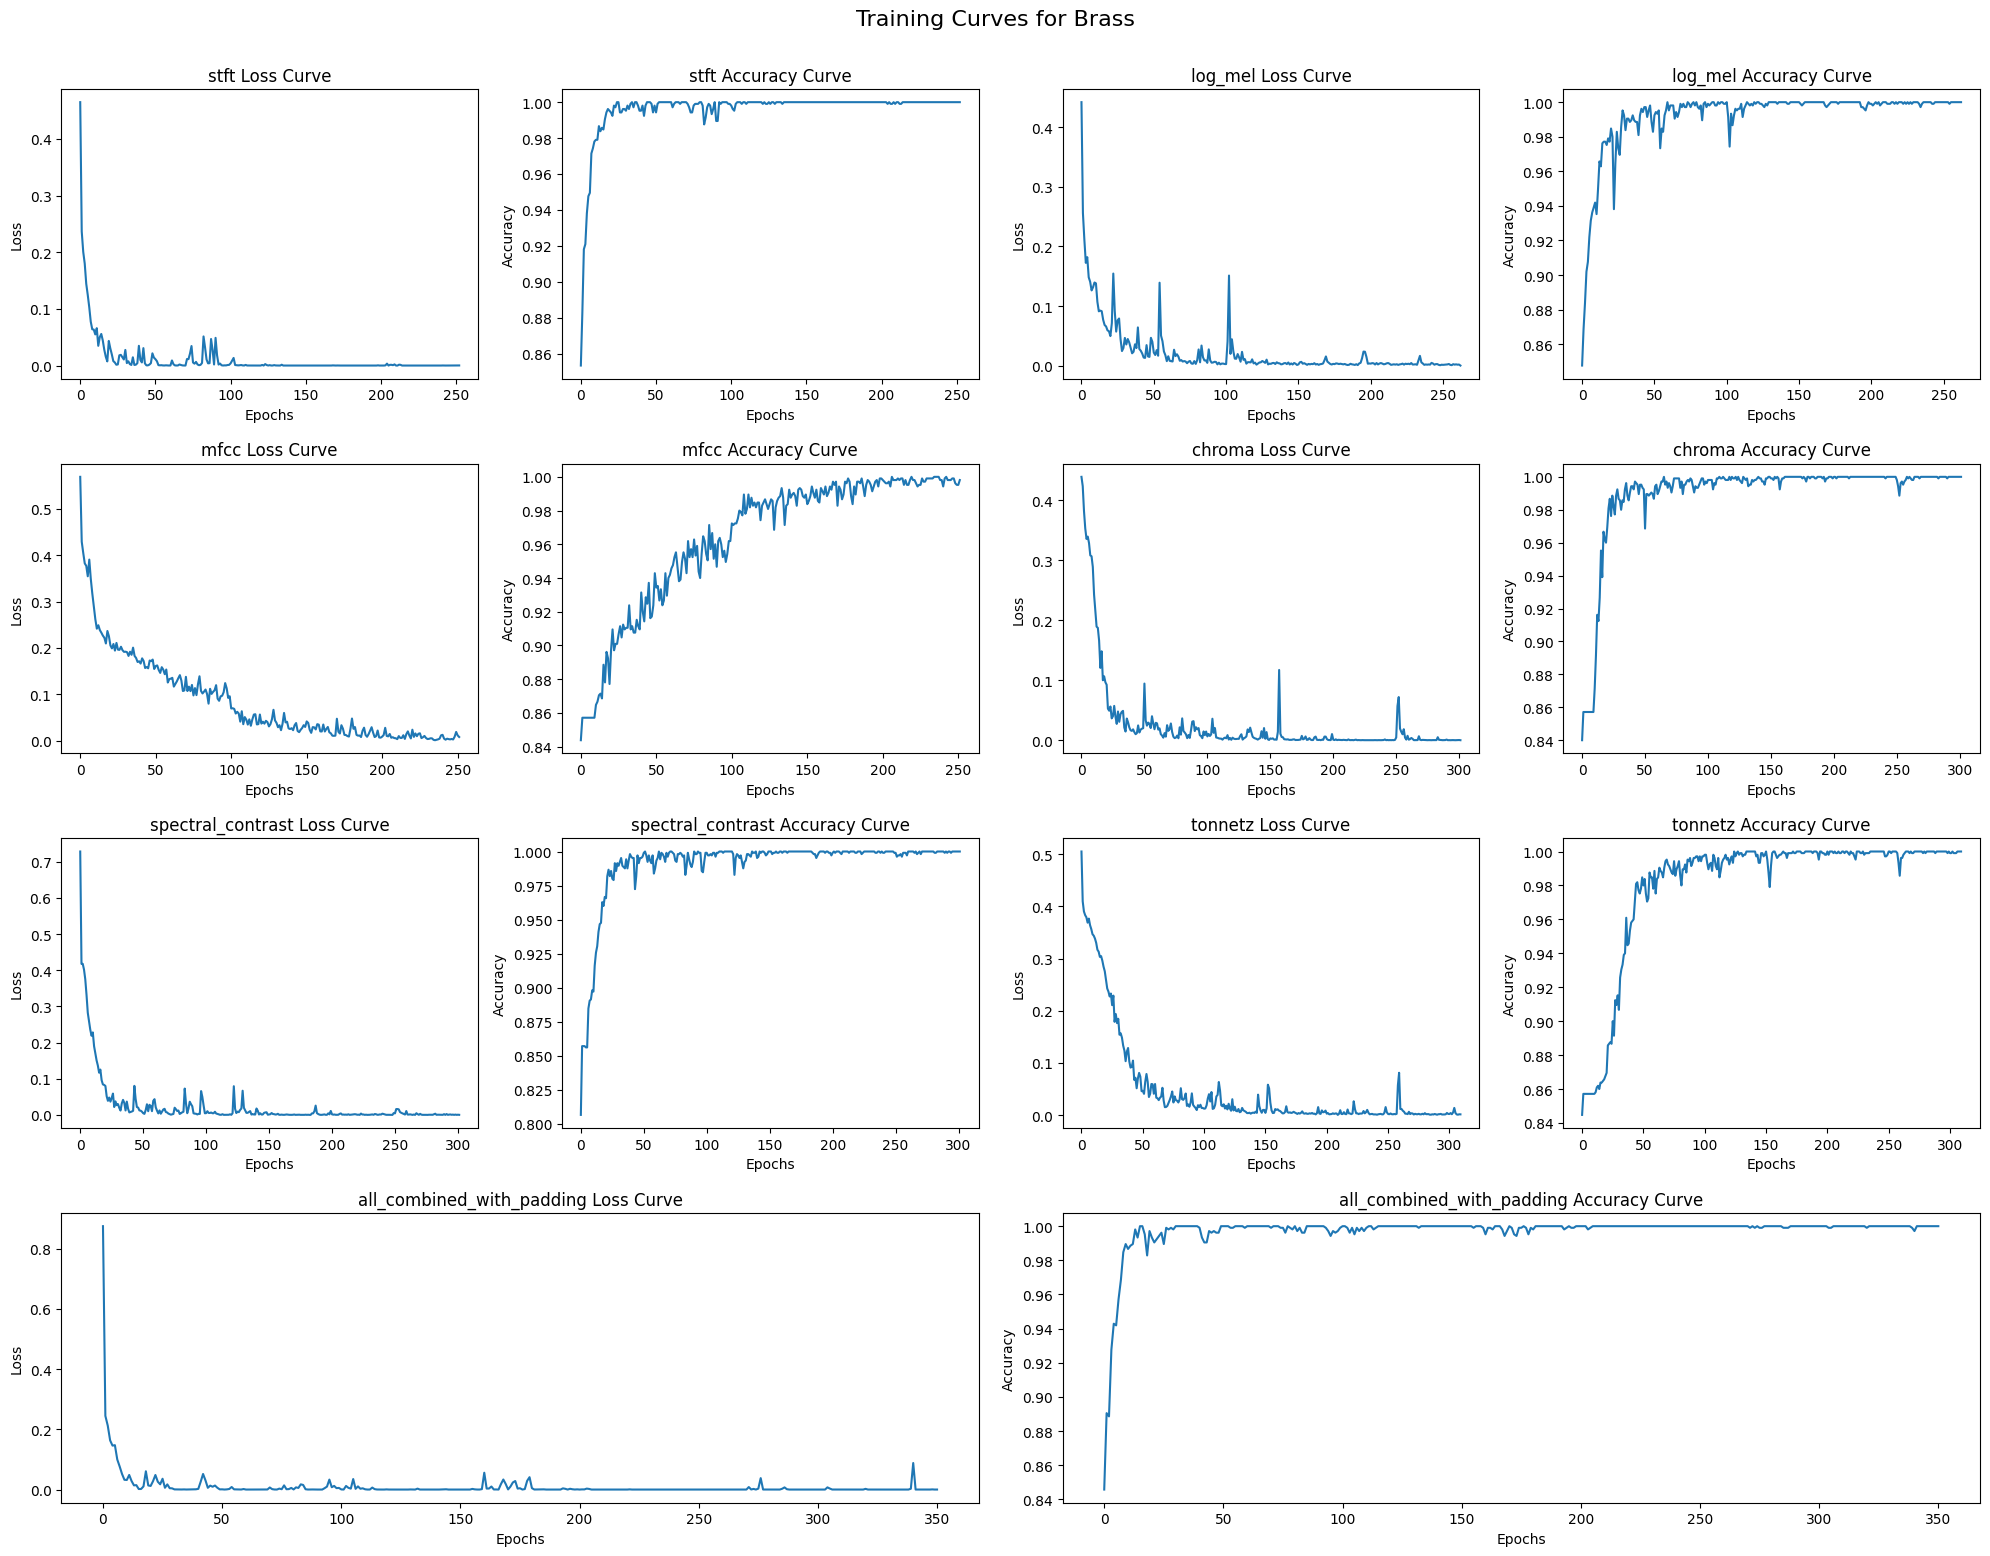

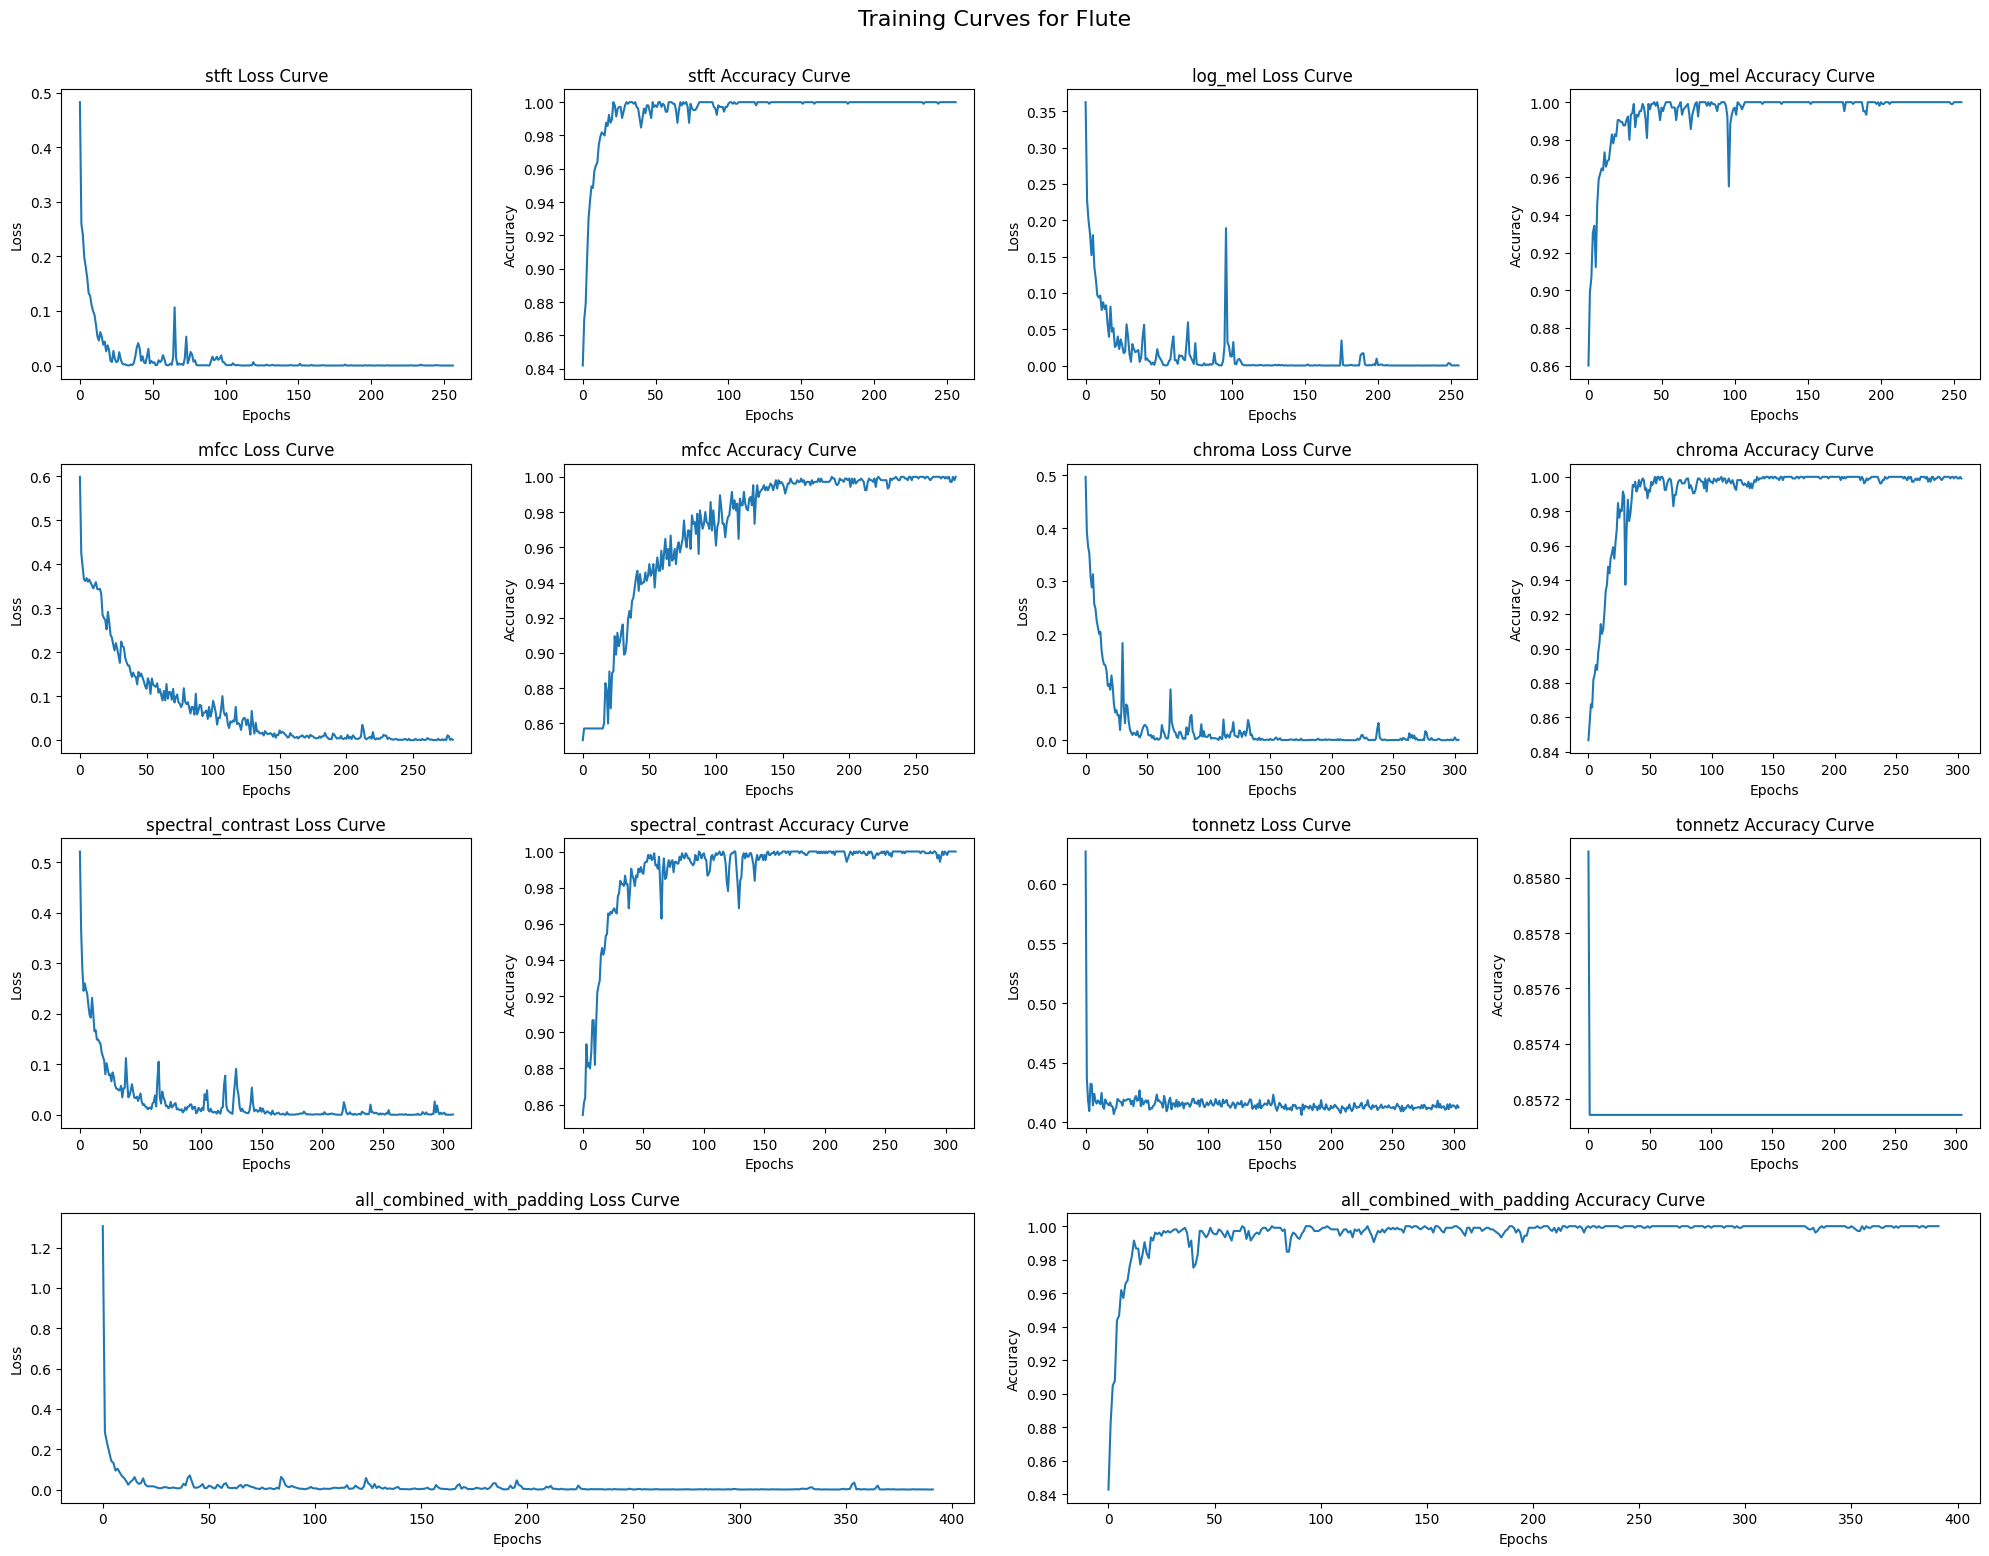

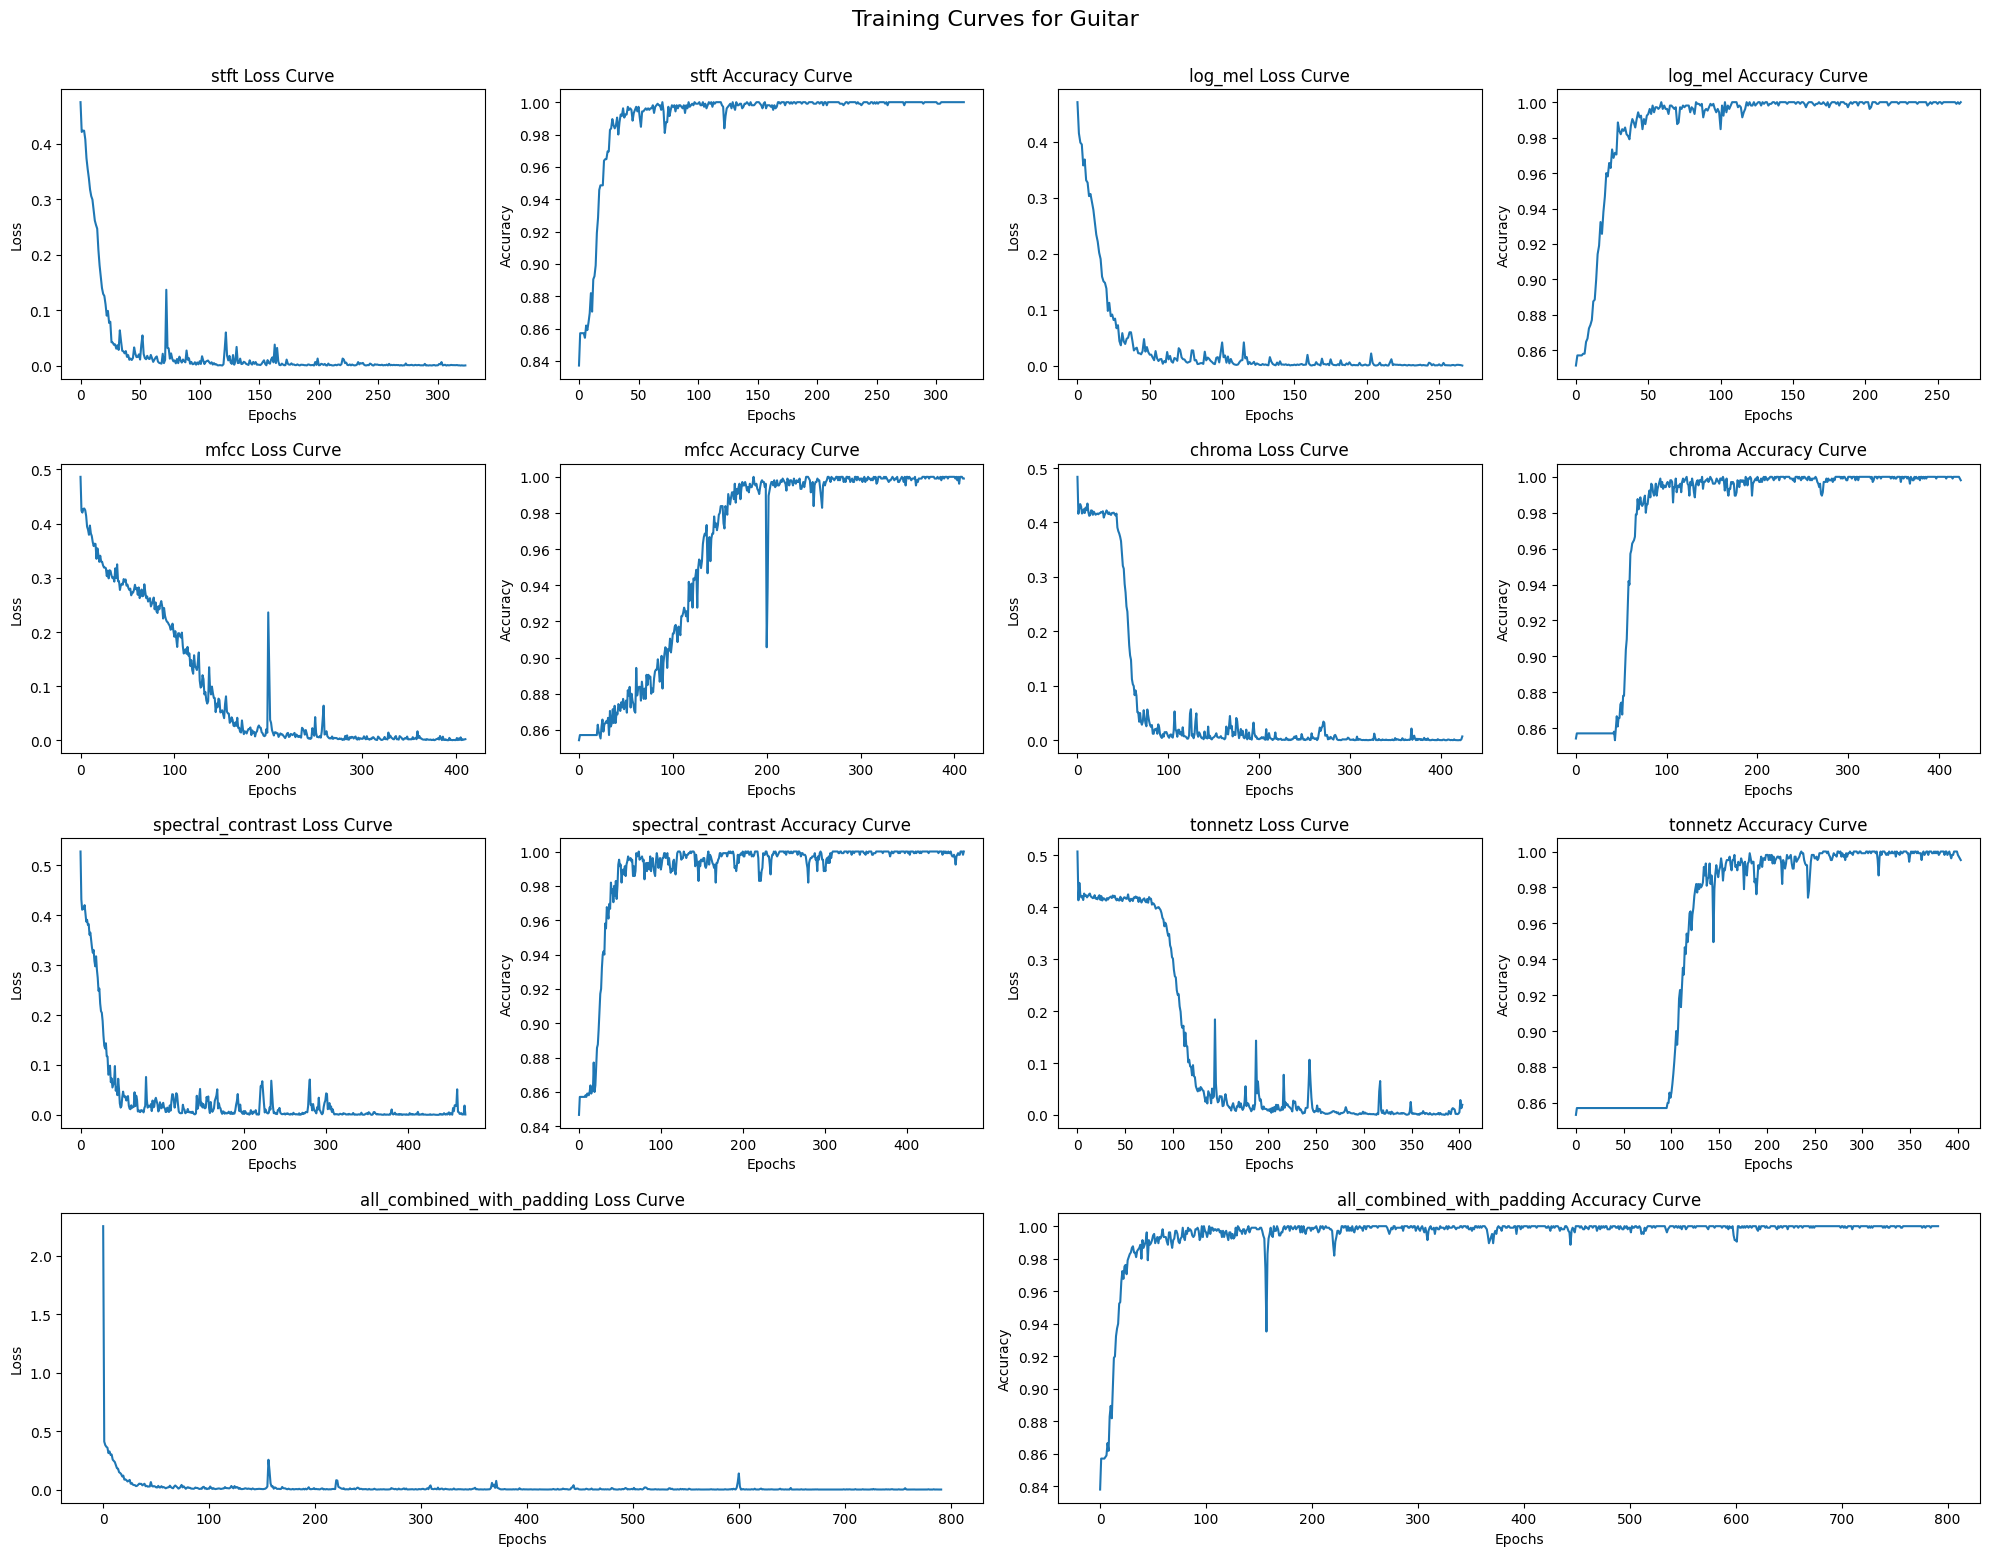

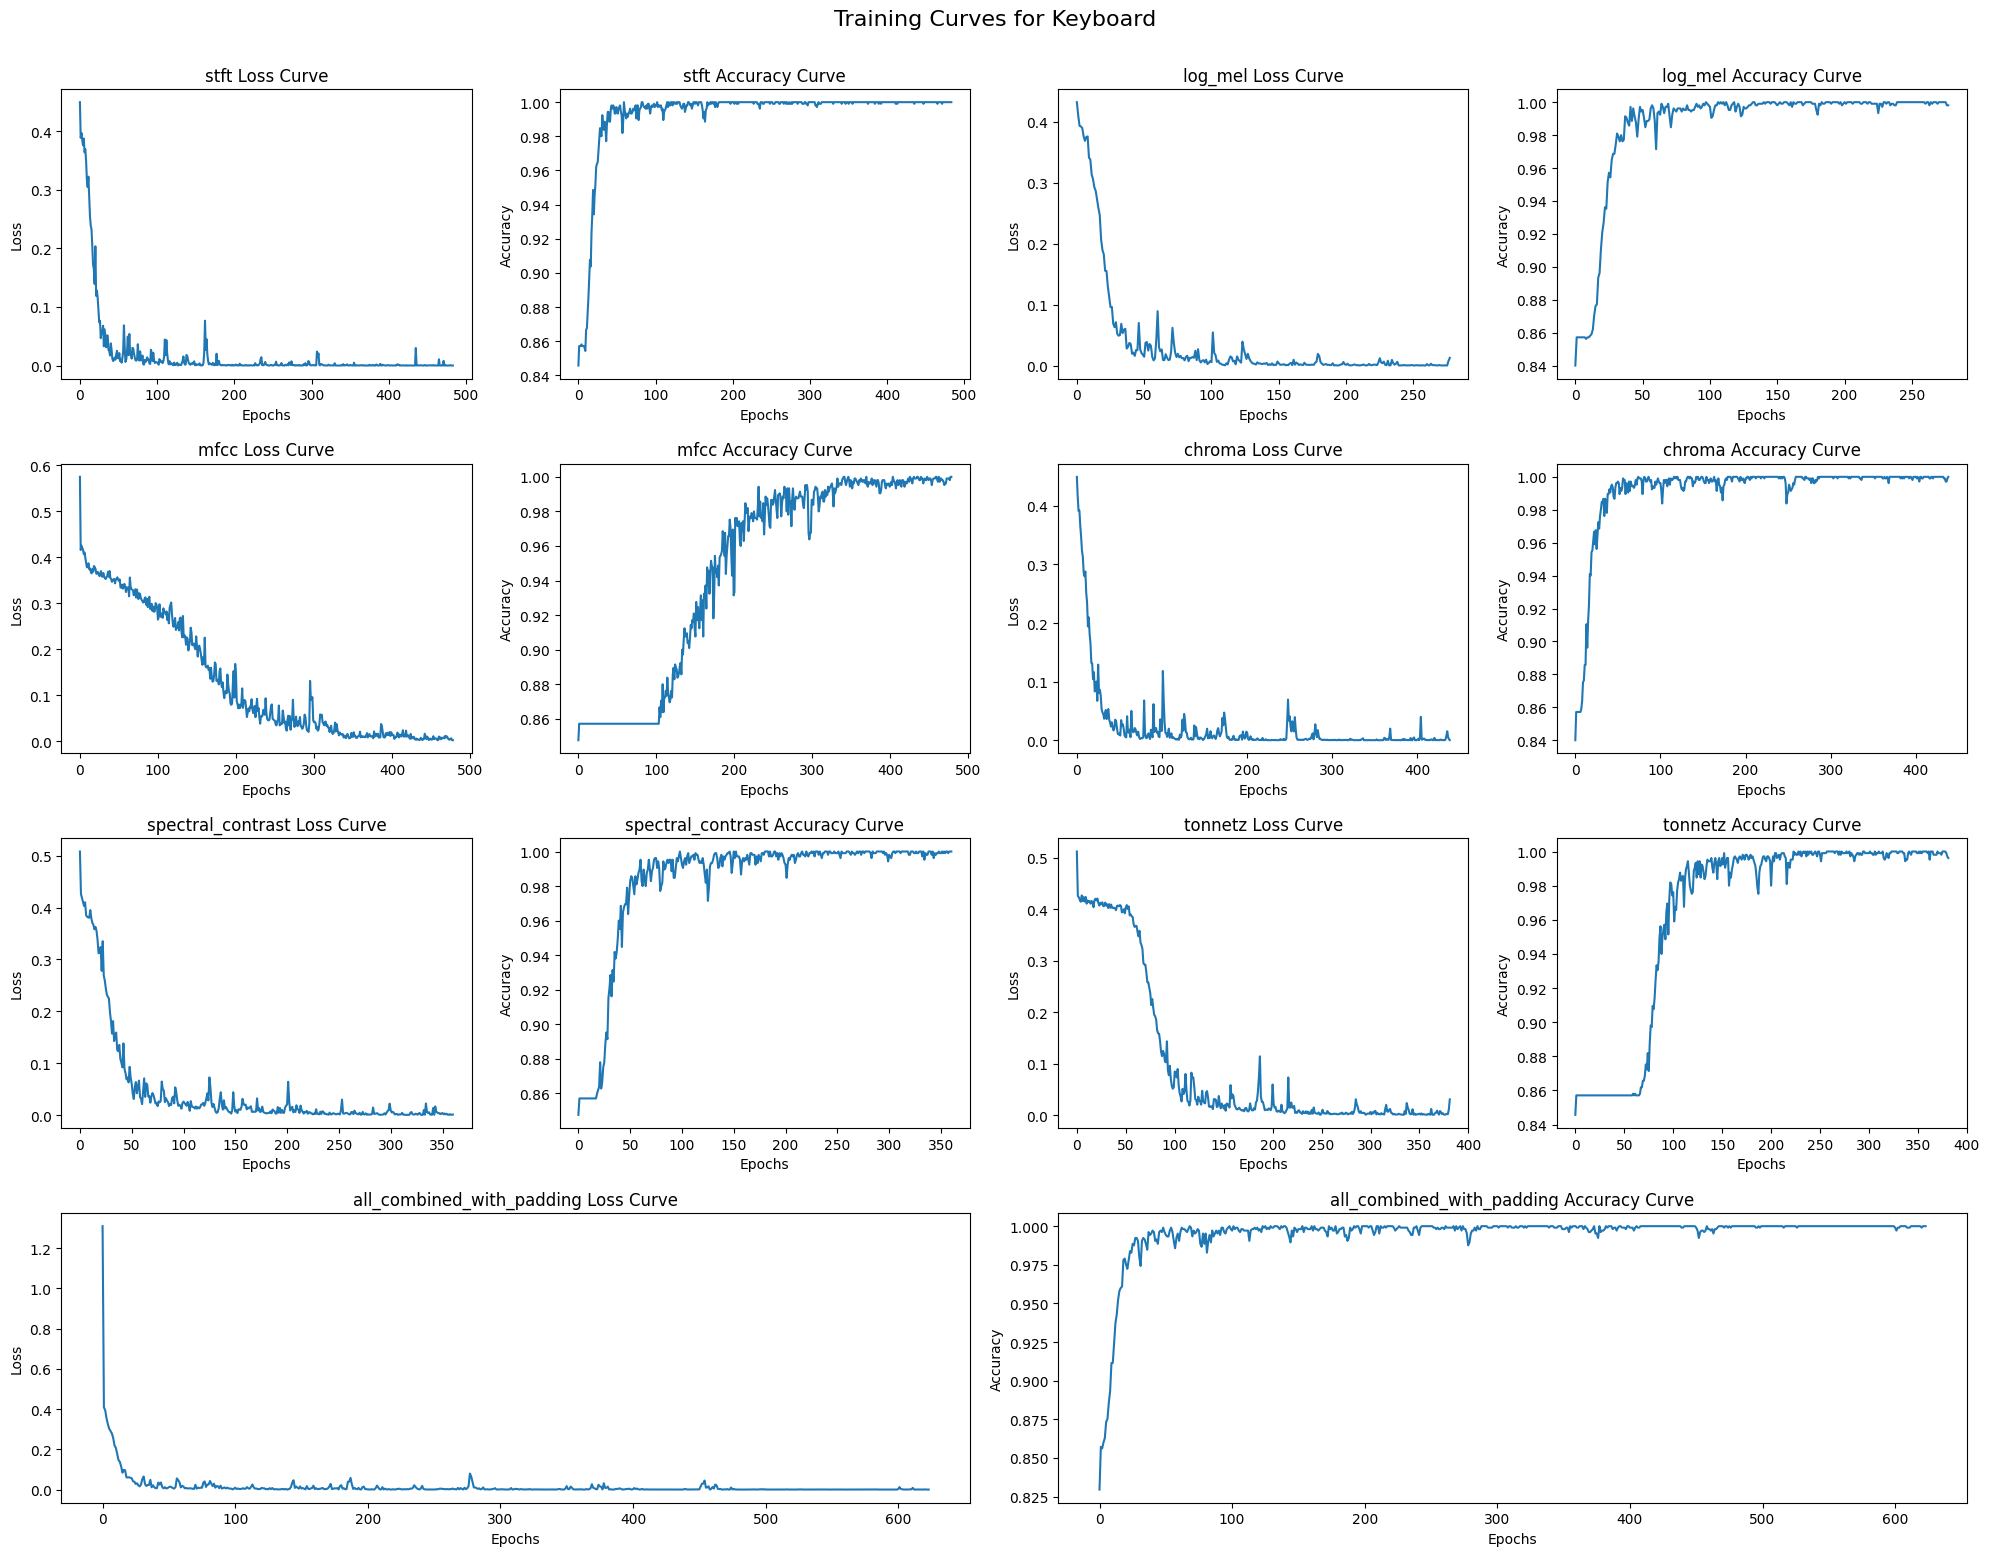

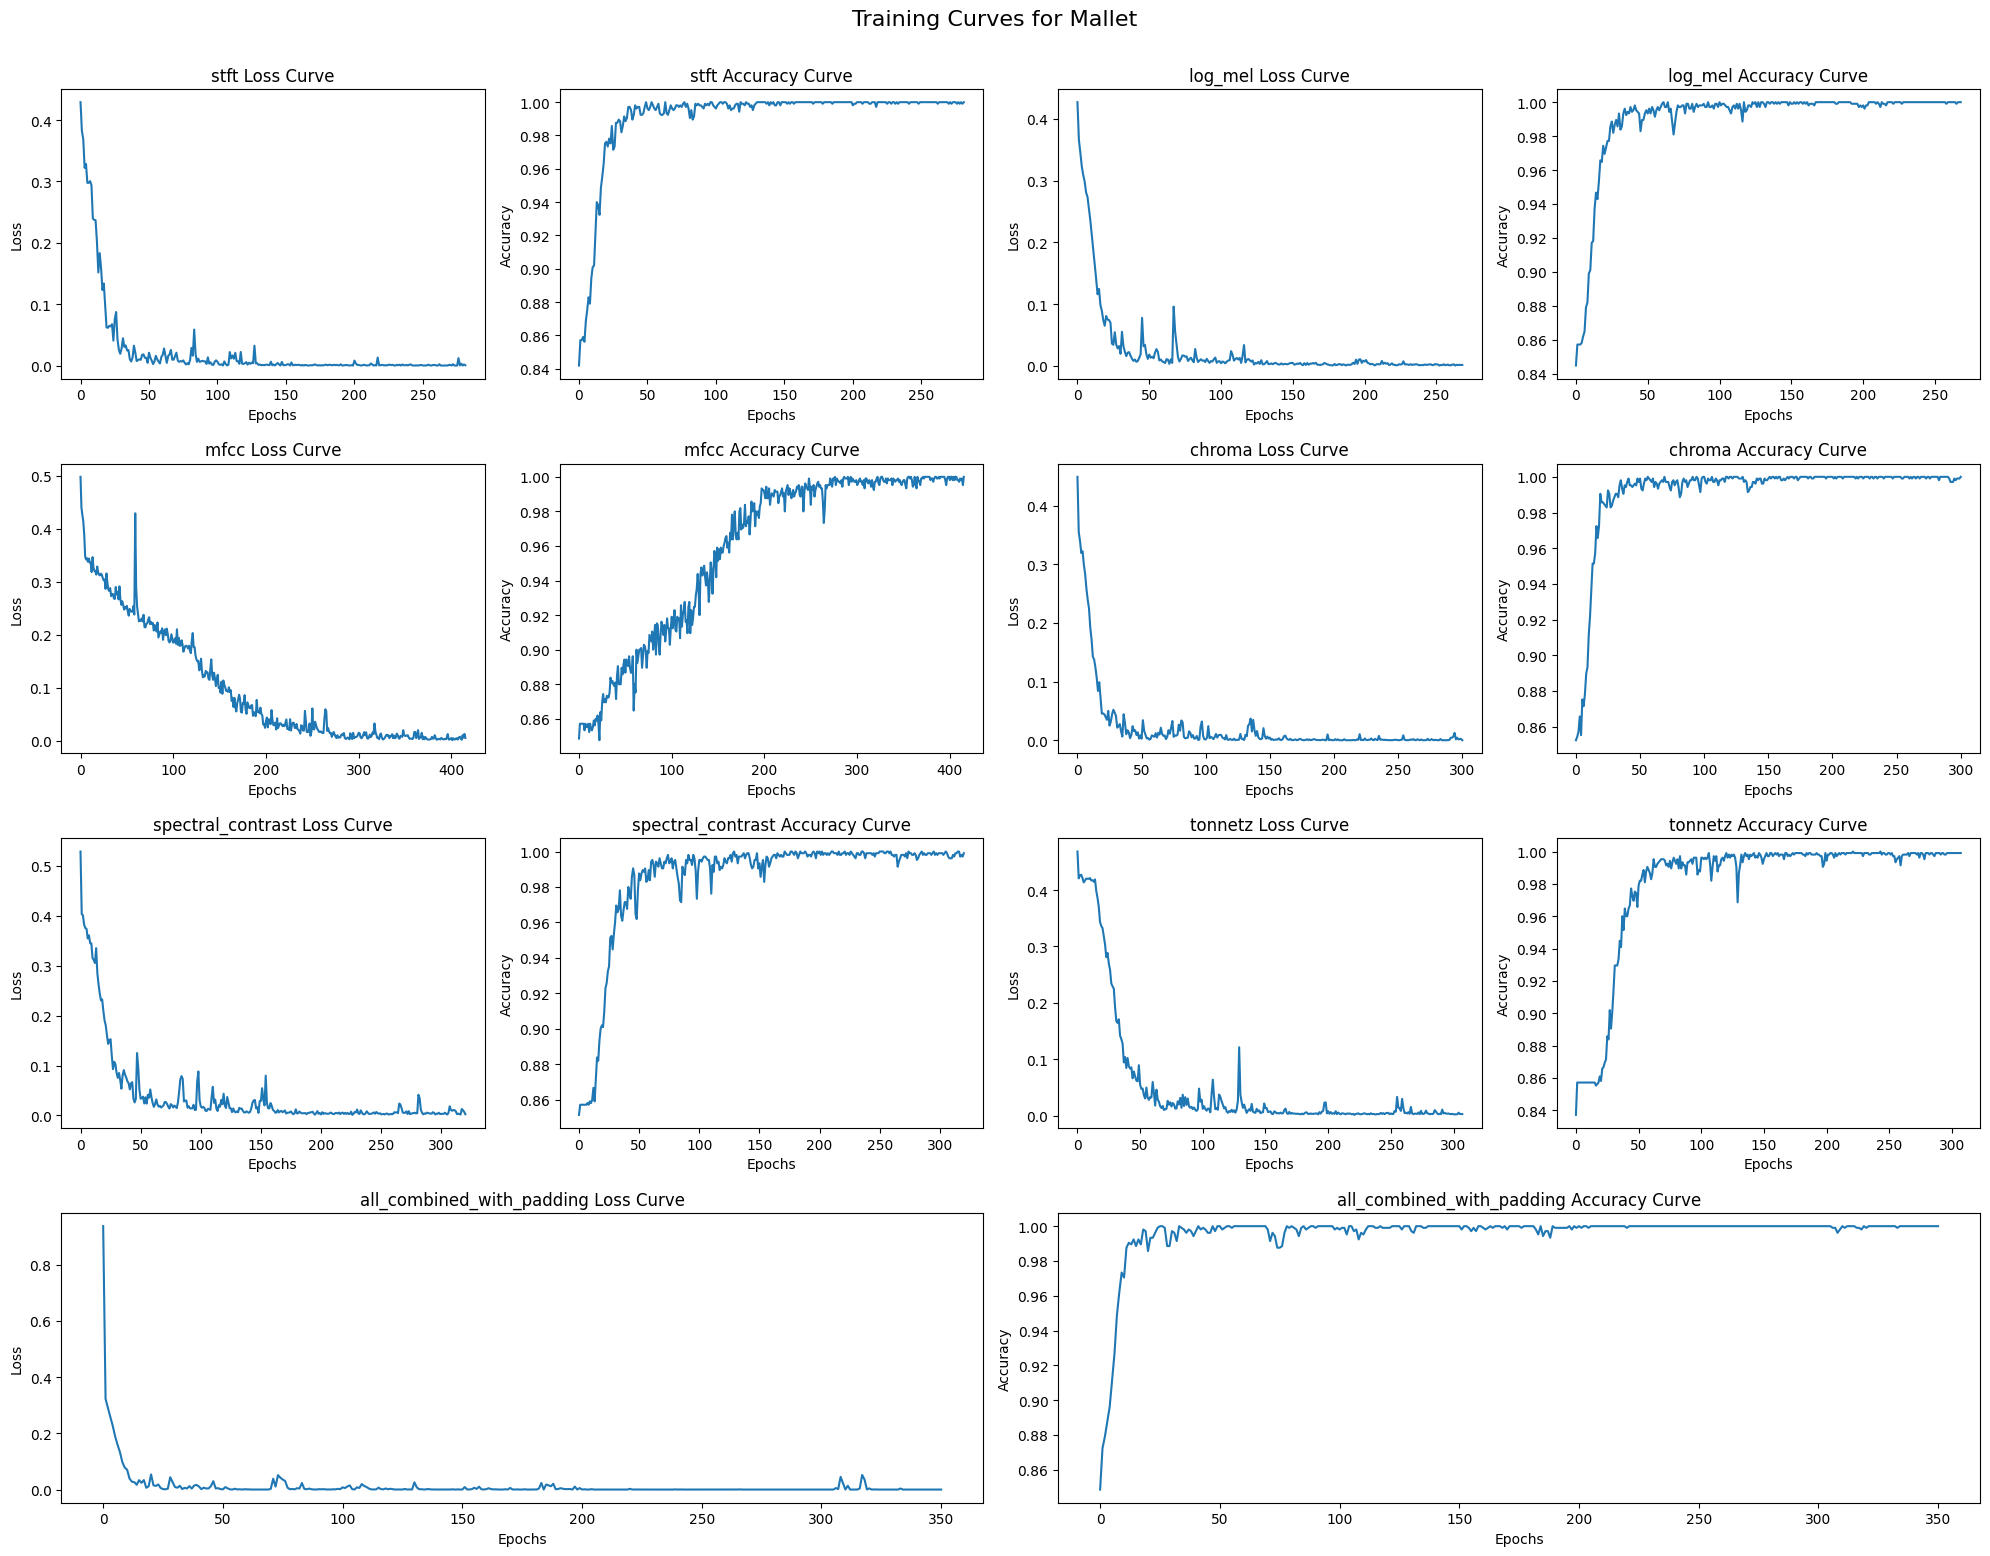

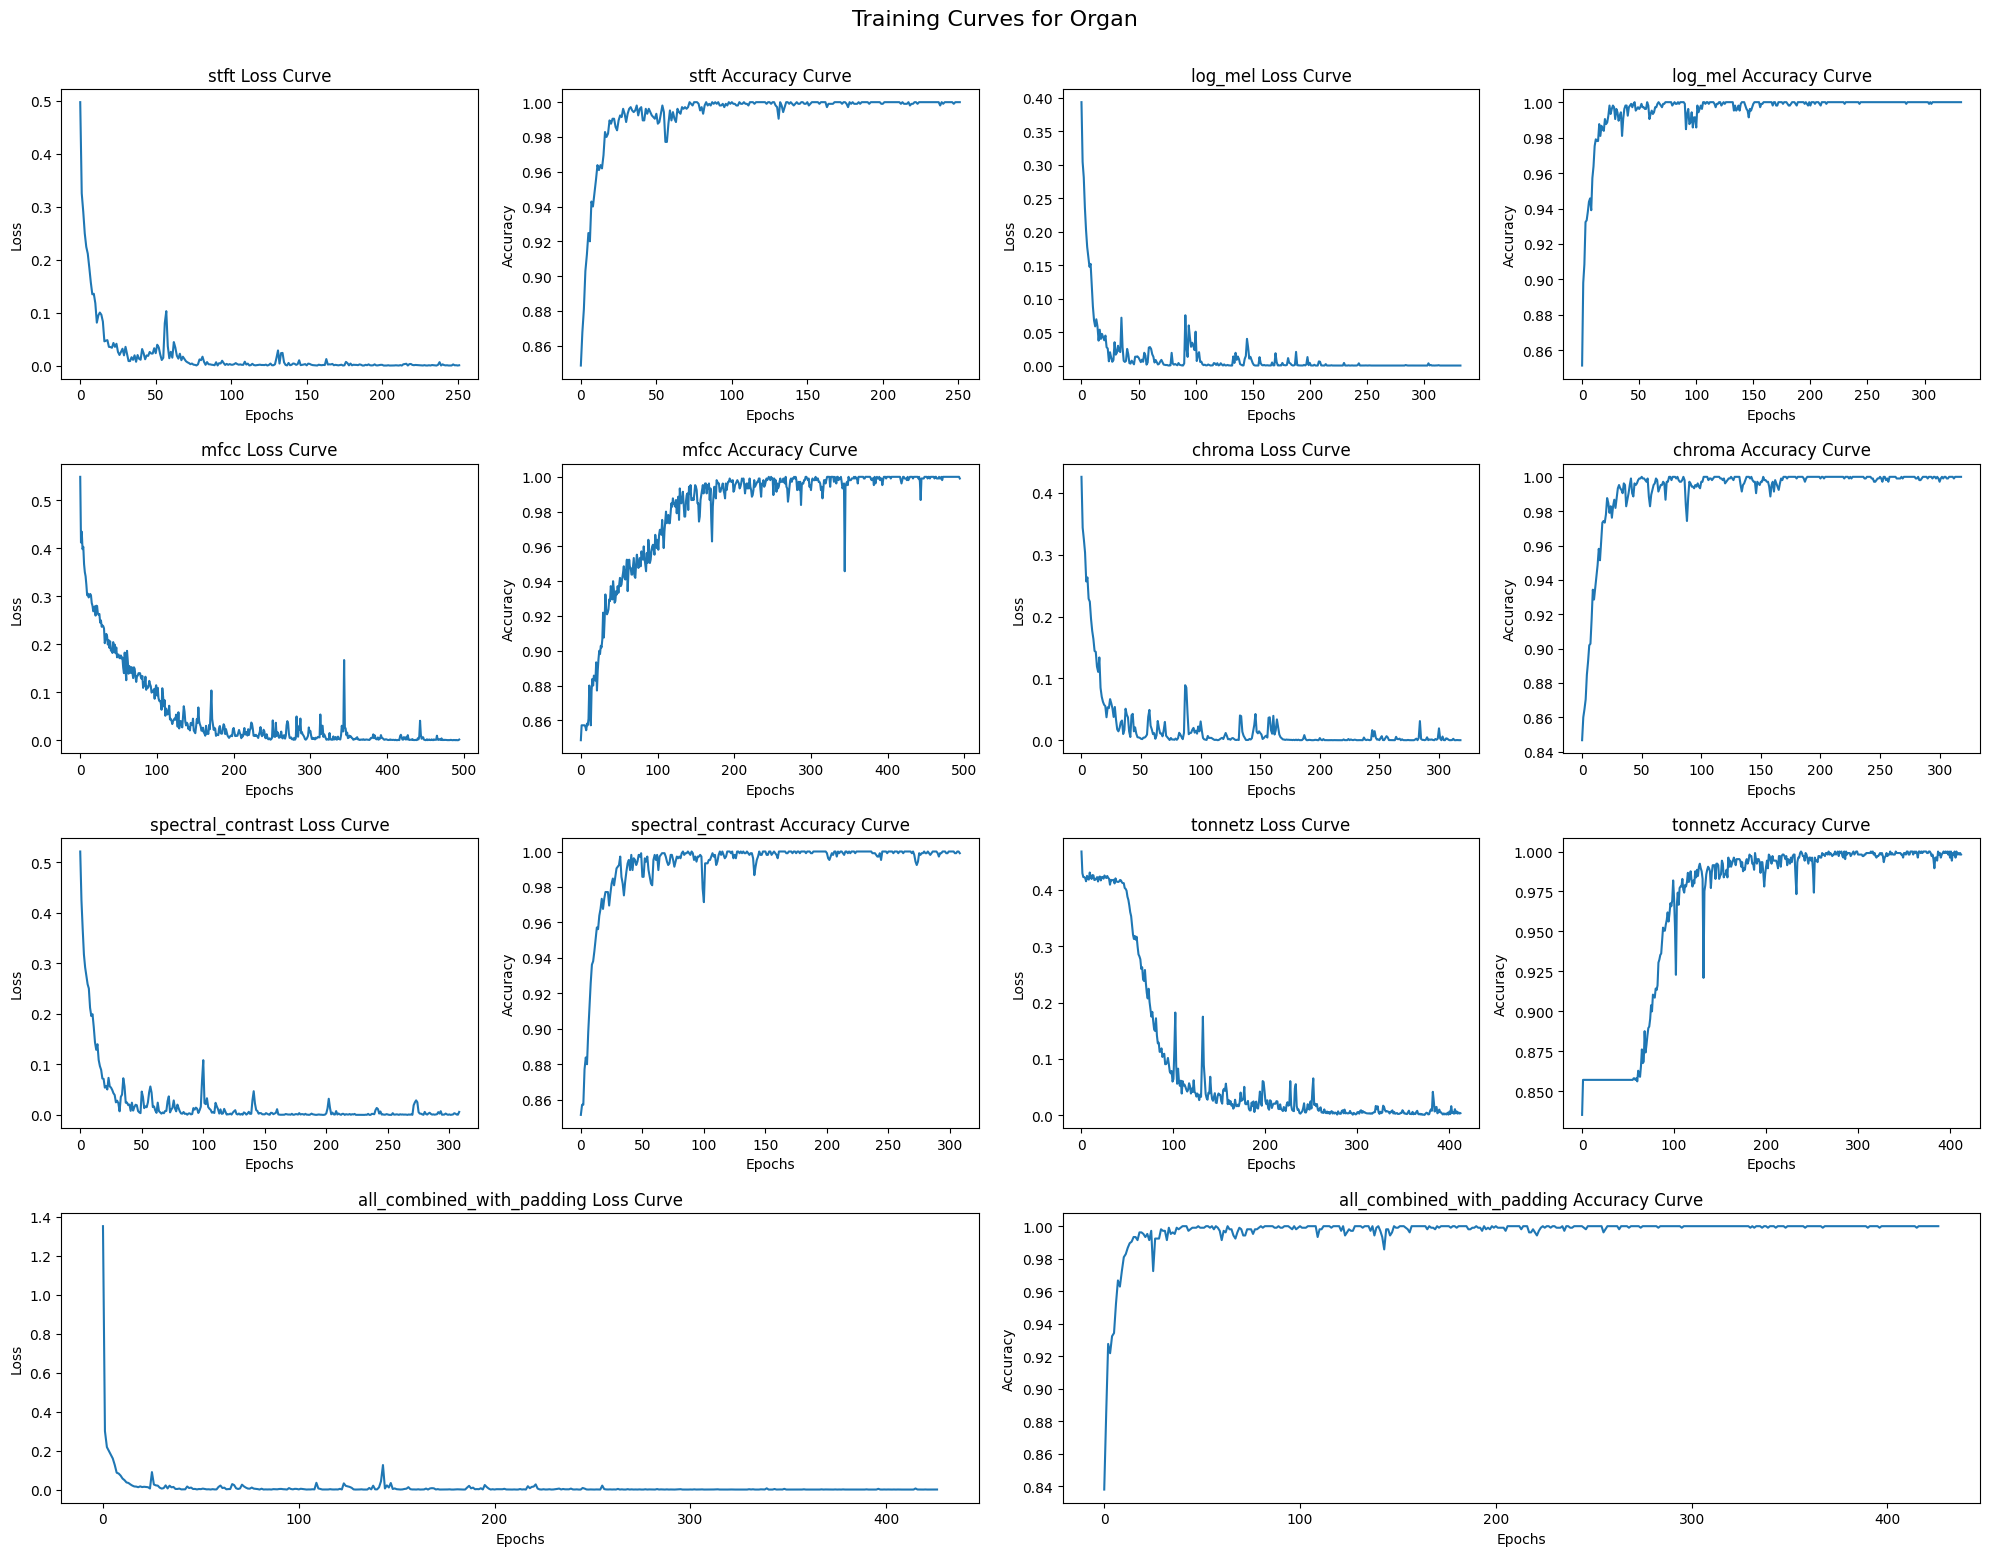

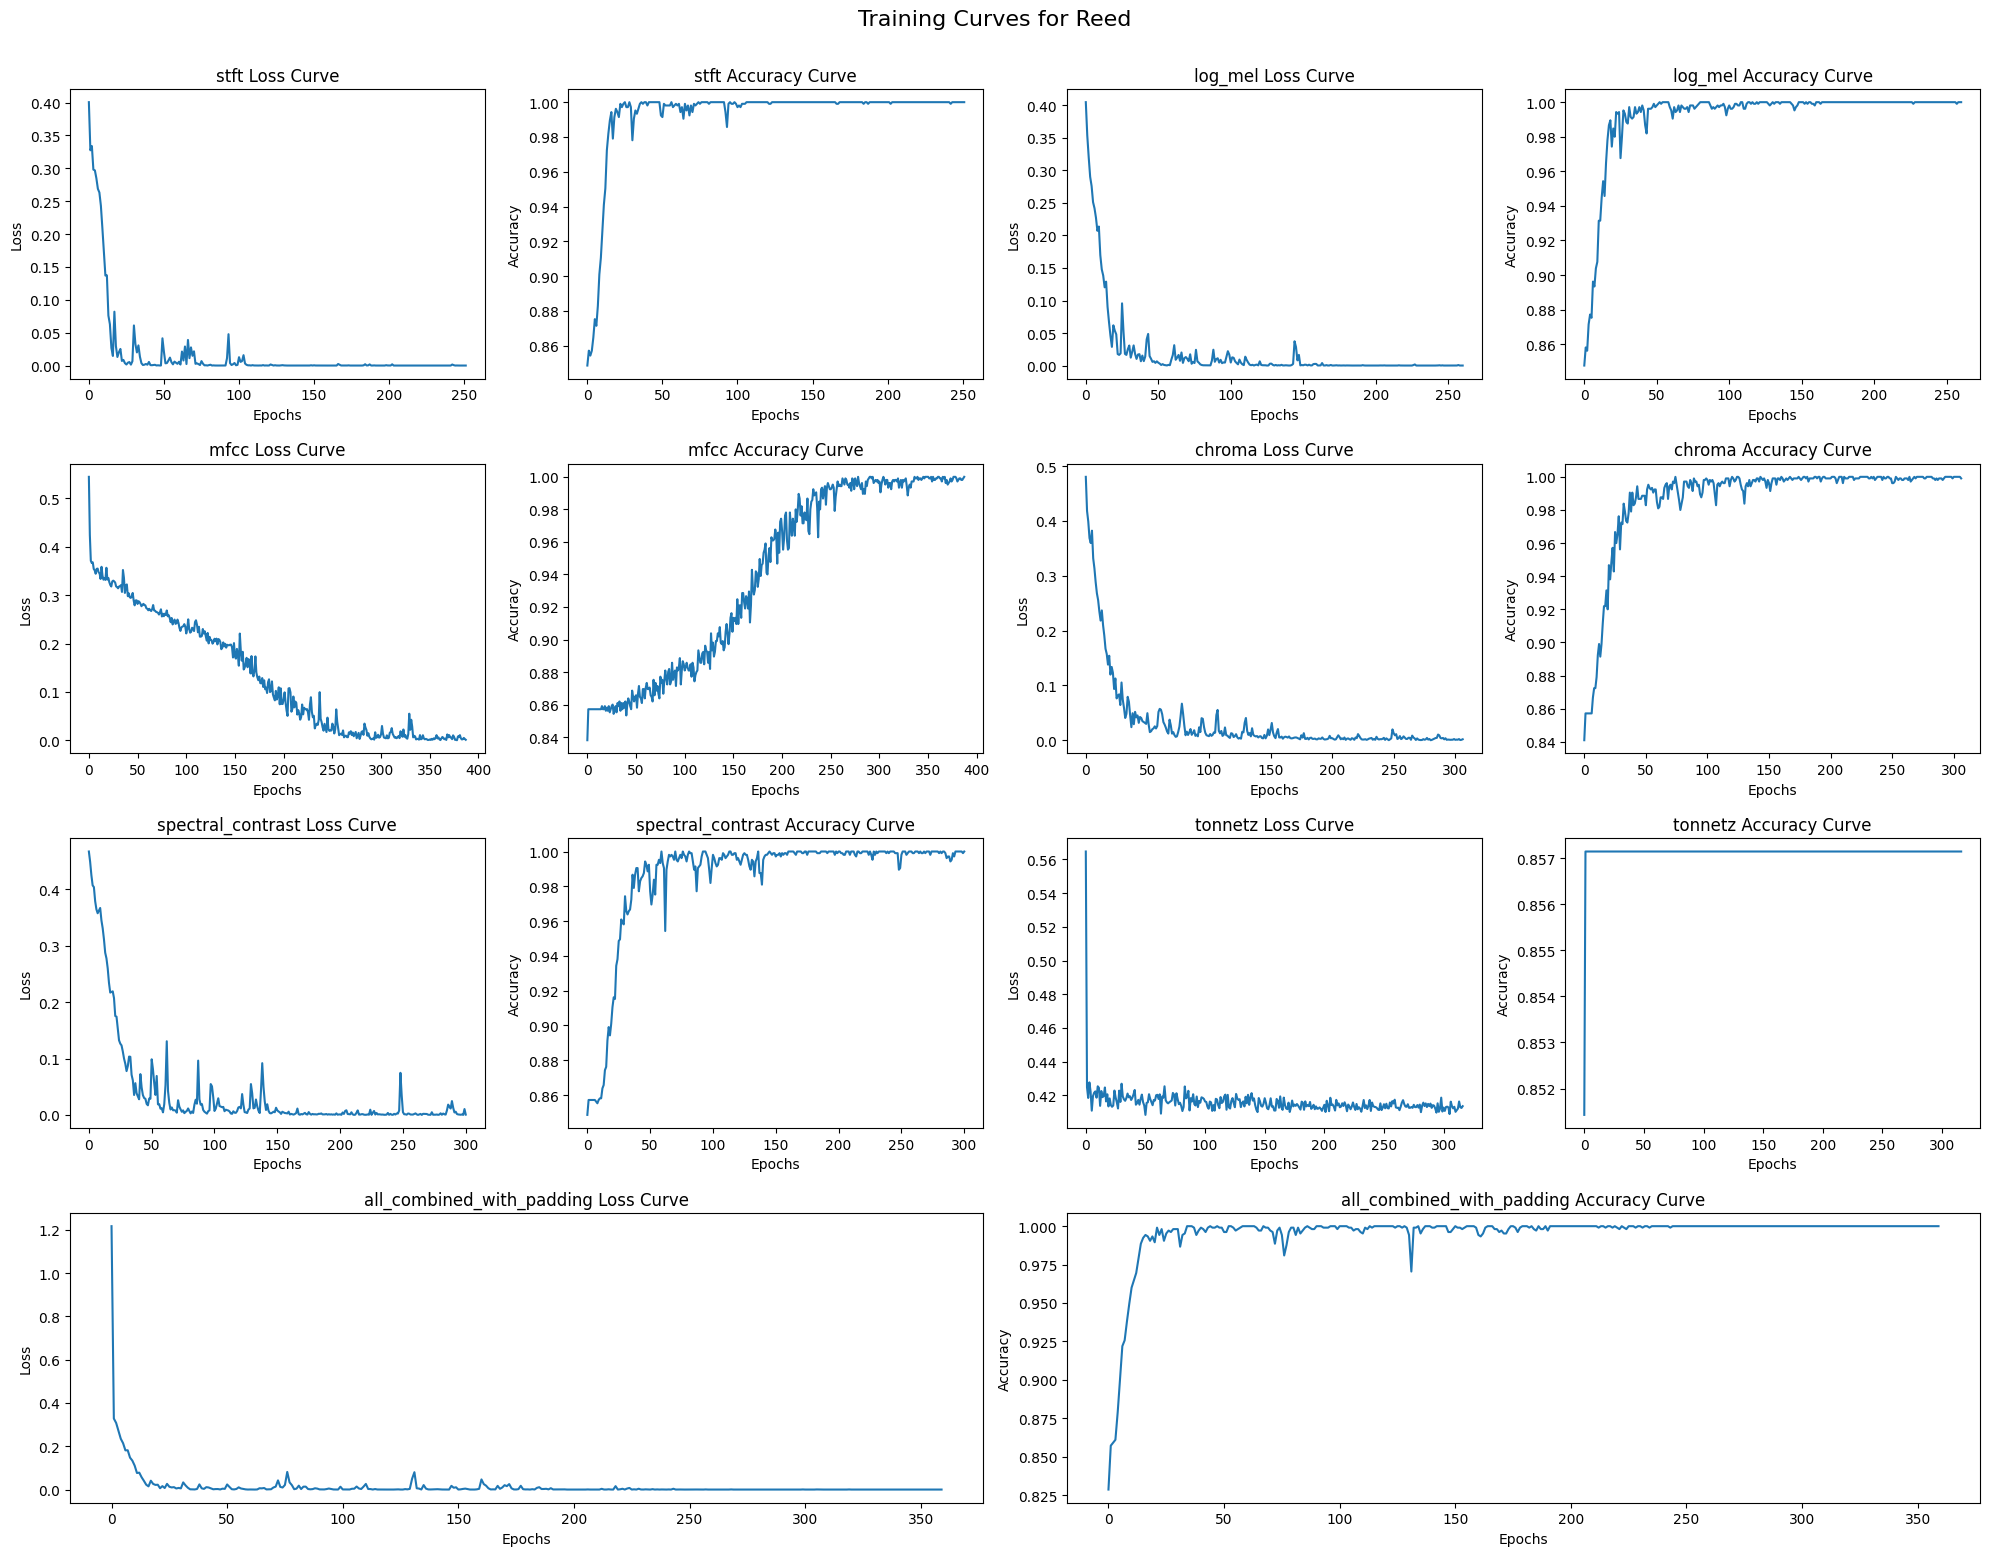

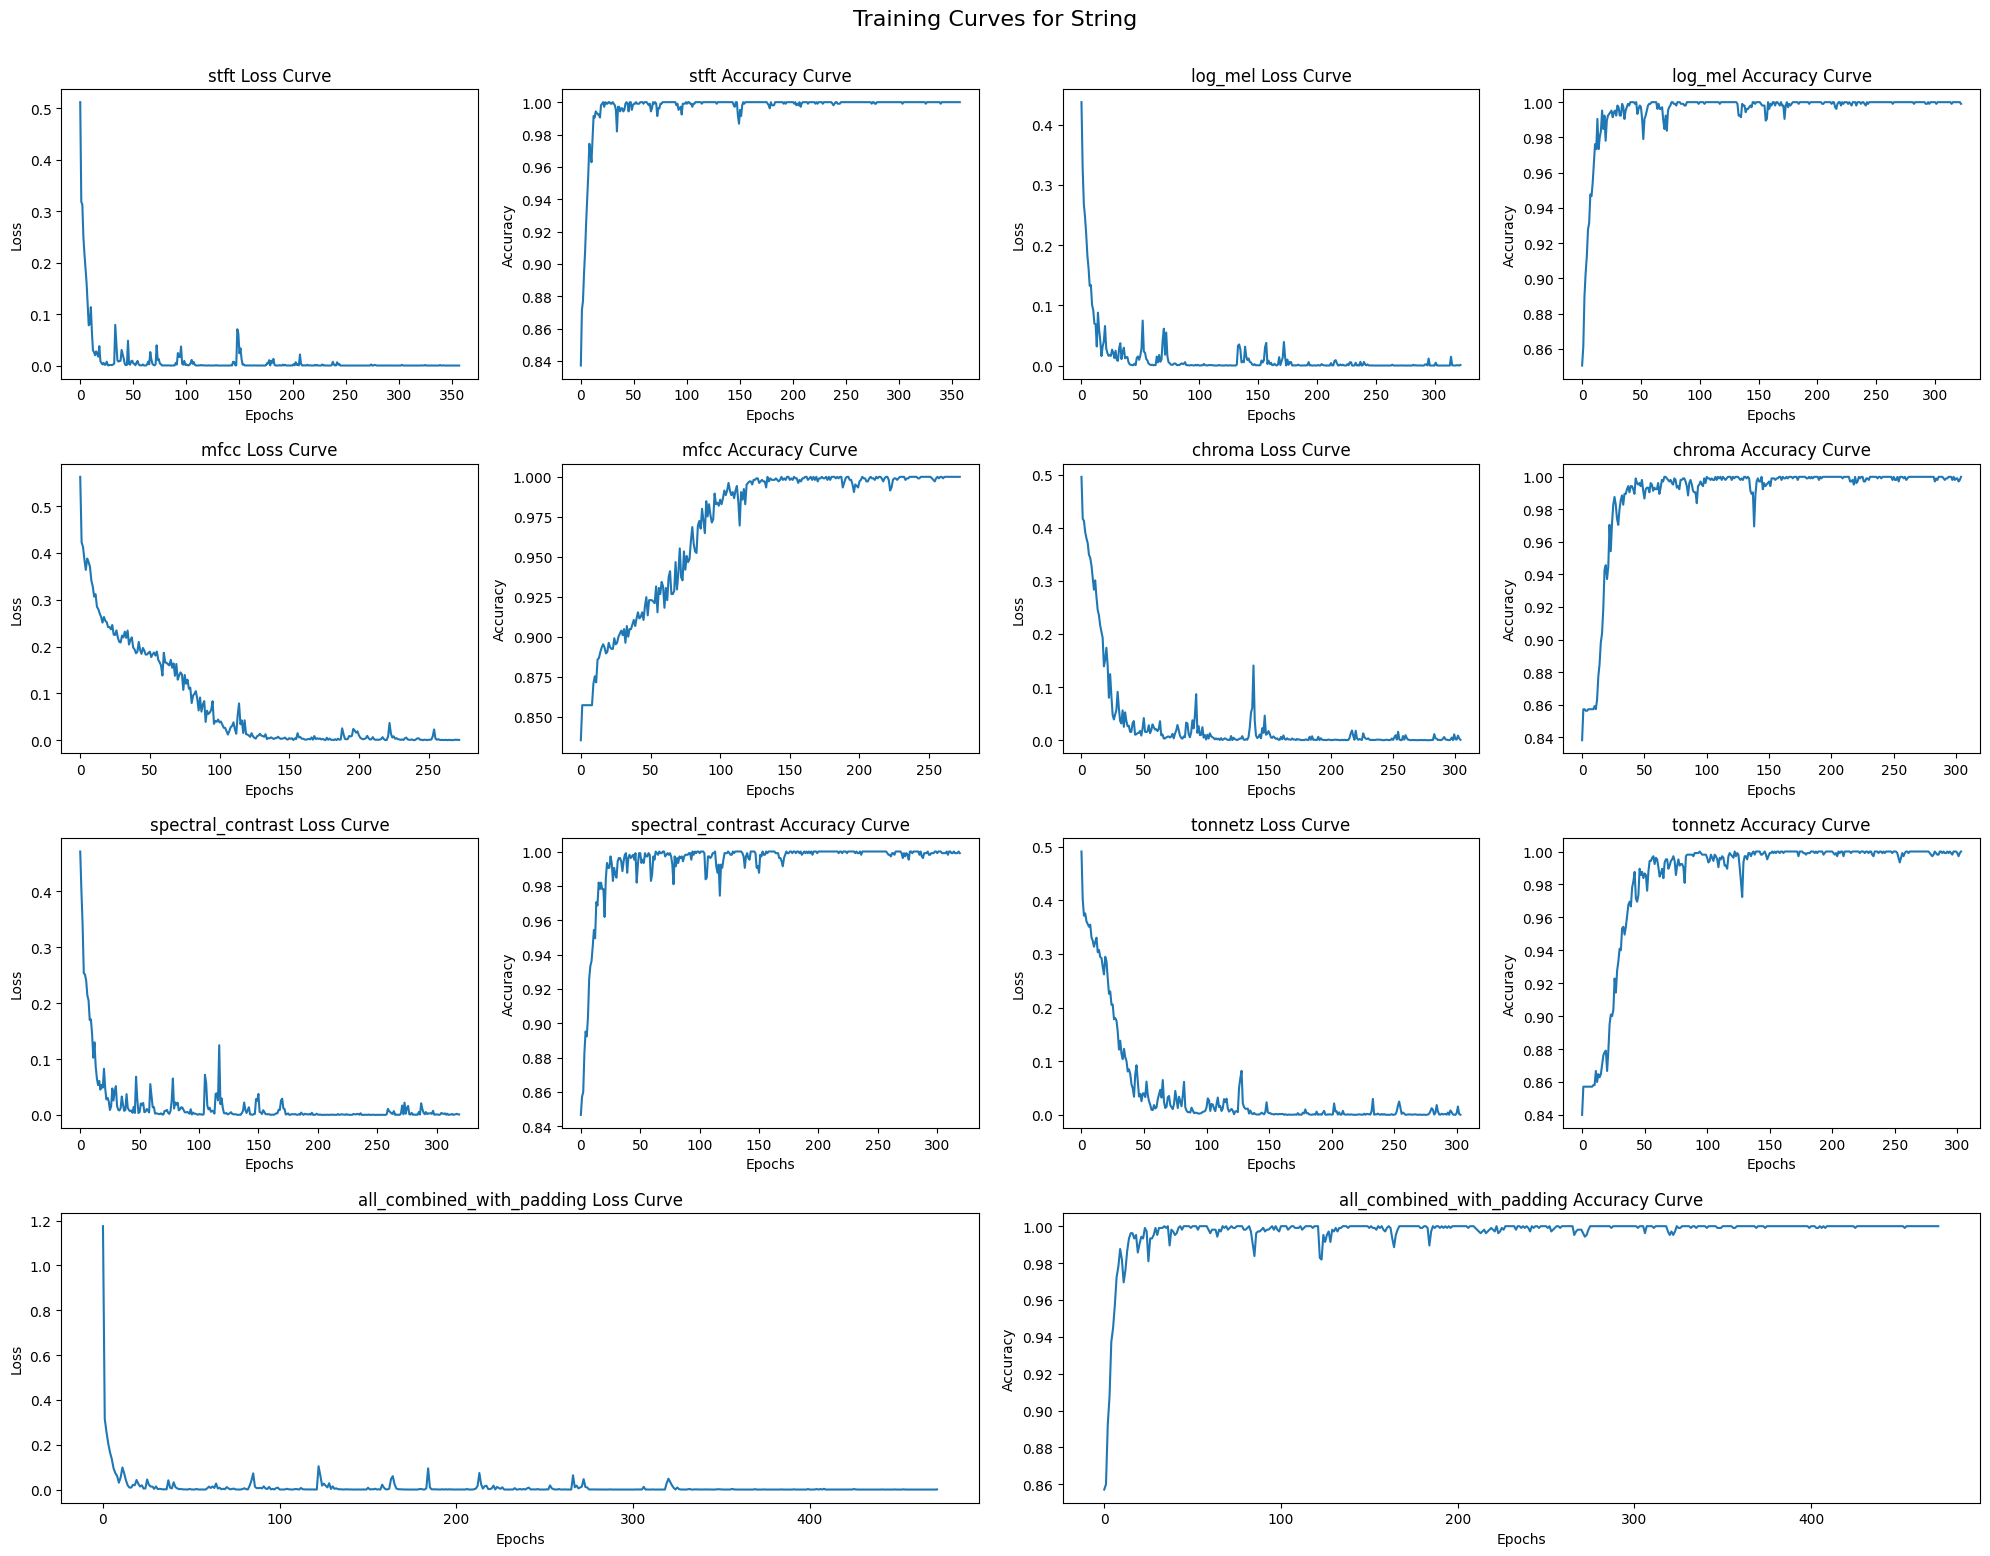

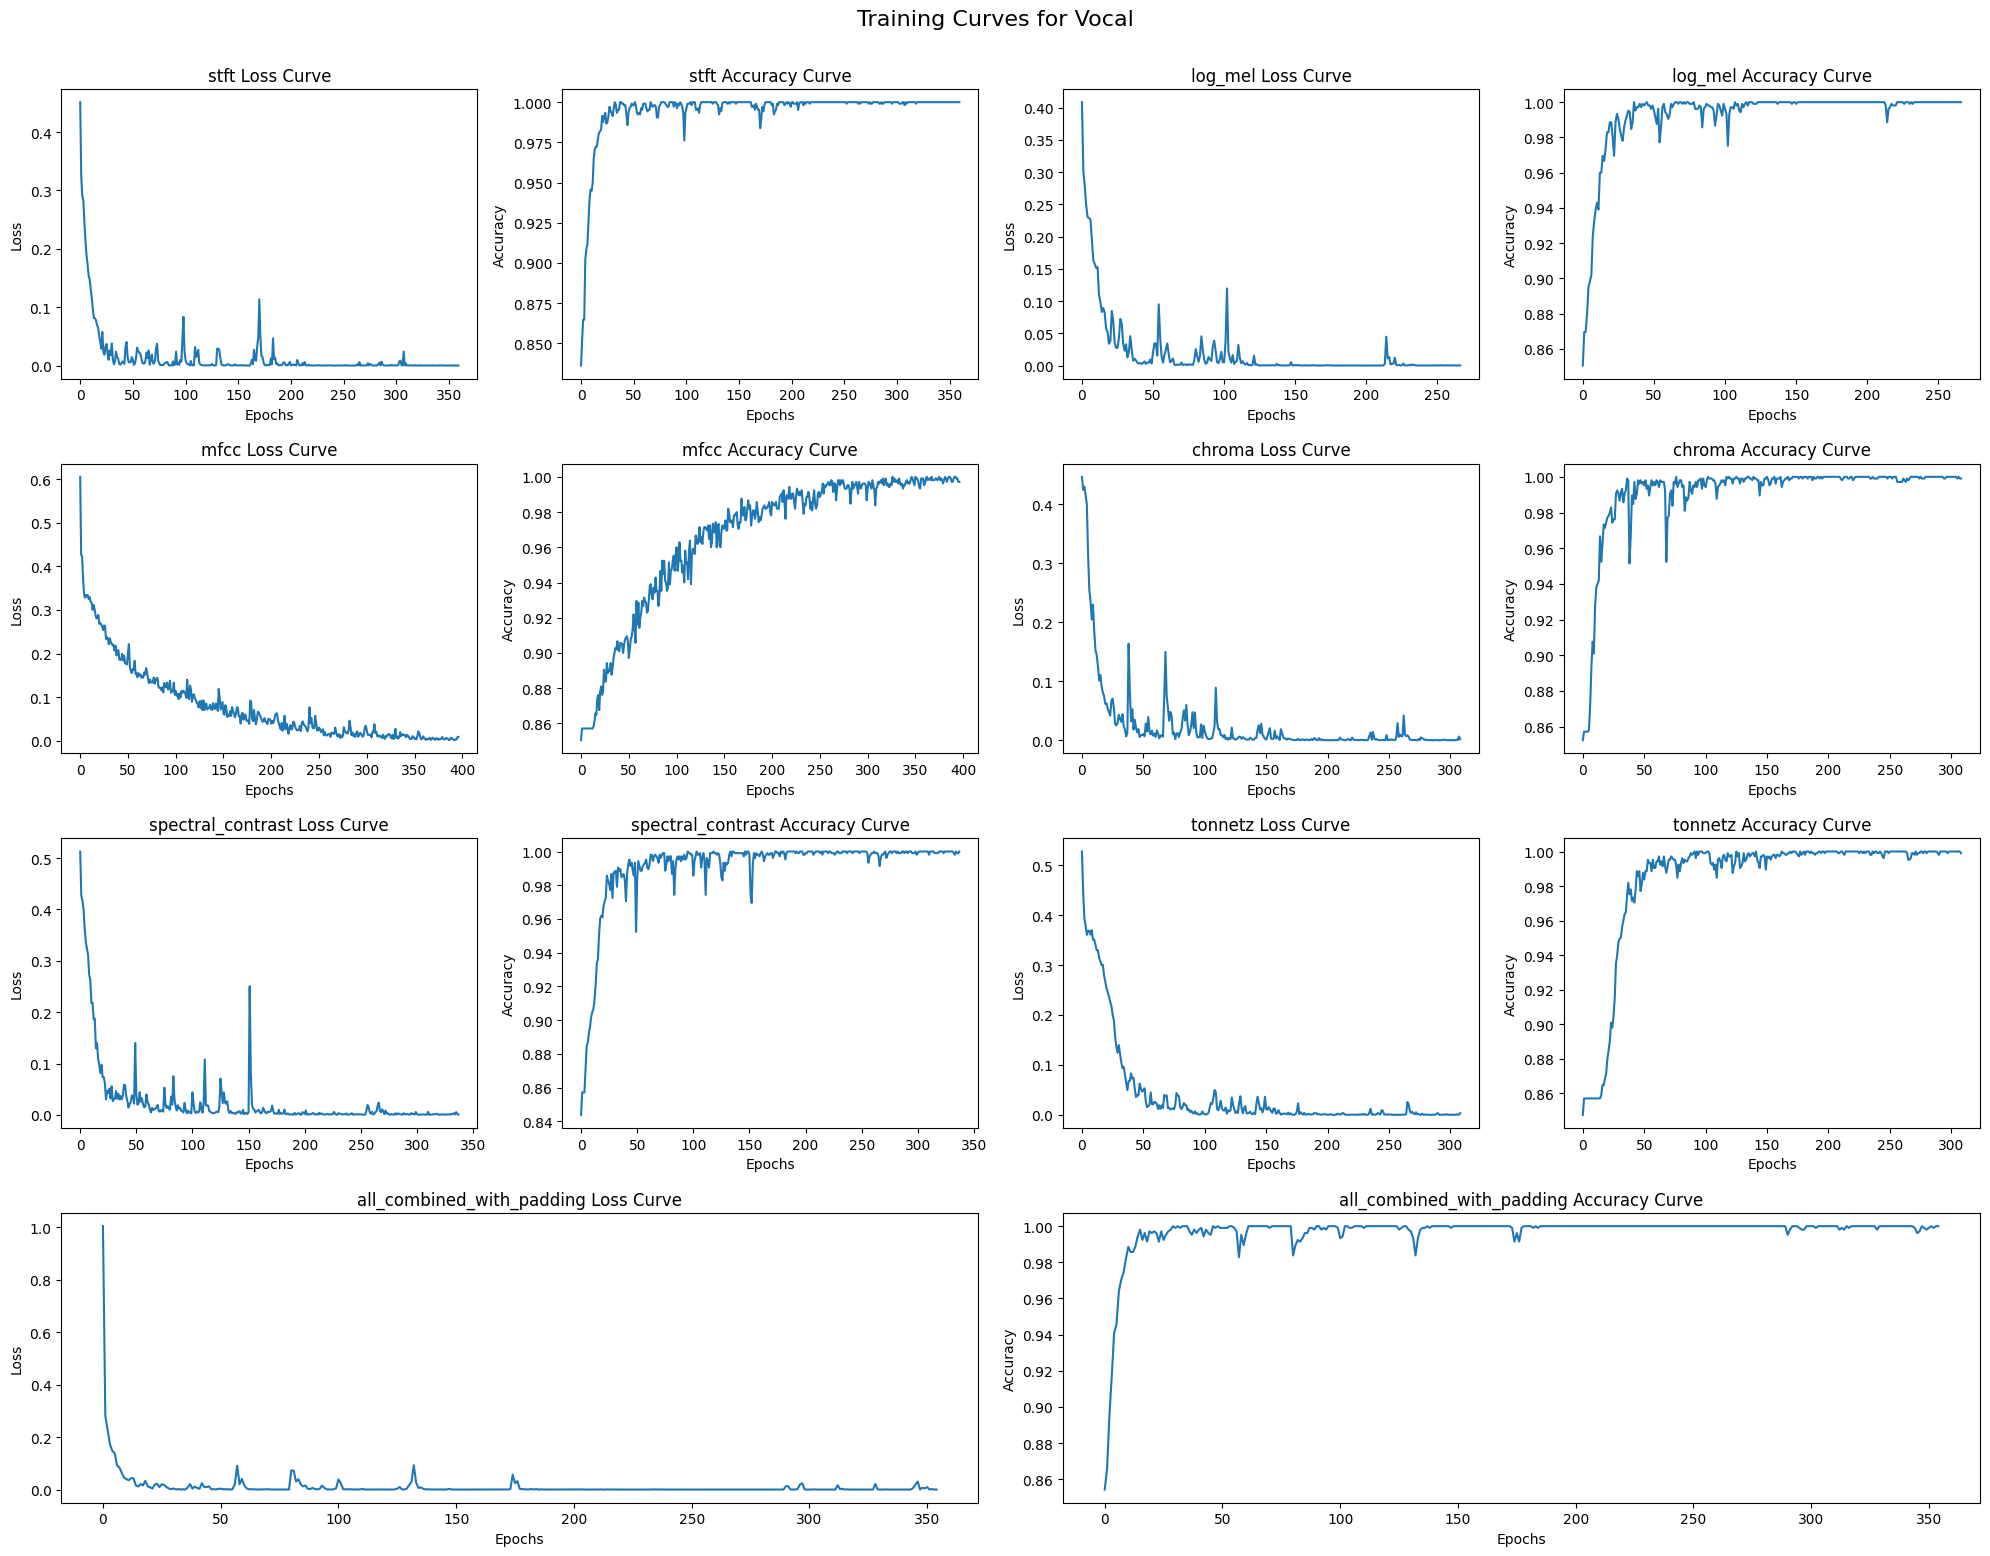

Plotting and saving of training curves completed.


In [ ]:
# Plot and save training curves for each instrument
for instrument in instrument_families:
    plot_training_curves(instrument)

print("Plotting and saving of training curves completed.")

In [8]:
# Example parameters
plot_spectrogram = 'stft'
model_name = 'bass'
intermediate_heatmap_layer = 'conv2d'
sample_index = 0

In [ ]:
# Load the model (assuming the models are saved with a naming convention like 'model_{plot_spectrogram}_{model_name}.h5')
model_path = os.path.join(models_dir, plot_spectrogram, f'{plot_spectrogram}_{model_name}.h5')
loaded_model = tf.keras.models.load_model(model_path)

In [25]:
for layer in loaded_model.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")


conv2d: trainable = True
conv2d_1: trainable = True
max_pooling2d: trainable = True
dropout: trainable = True
conv2d_2: trainable = True
conv2d_3: trainable = True
max_pooling2d_1: trainable = True
dropout_1: trainable = True
conv2d_4: trainable = True
conv2d_5: trainable = True
max_pooling2d_2: trainable = True
dropout_2: trainable = True
flatten: trainable = True
dense: trainable = True
dropout_3: trainable = True
dense_1: trainable = True


In [12]:
# Load the dataset (assuming x_data is pre-loaded or can be loaded here)
x_data = load_data(family=model_name, spectrogram_type=plot_spectrogram)

In [13]:
def create_intermediate_model(loaded_model, layer_name):
    intermediate_model = tf.keras.Model(
        inputs=loaded_model.input,
        outputs=loaded_model.get_layer(layer_name).output
    )
    return intermediate_model

# Create the intermediate model for the specified layer
intermediate_model = create_intermediate_model(loaded_model, intermediate_heatmap_layer)


1/1 [==============================] - 0s 348ms/step


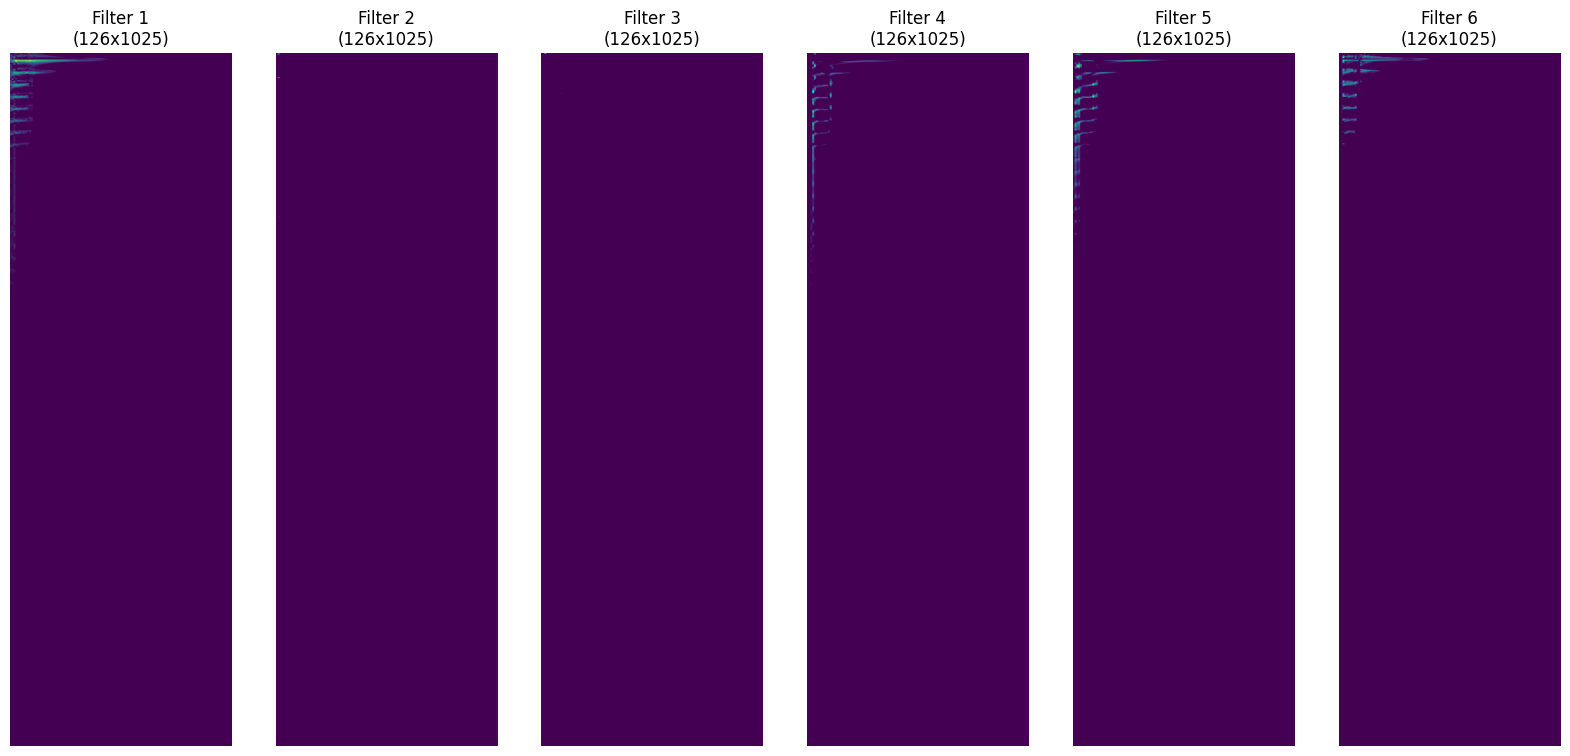

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_maps(intermediate_model, x_data, sample_index=0, aspect_ratio='auto'):
    output = intermediate_model.predict(np.expand_dims(x_data[sample_index], axis=0))

    num_filters = output.shape[-1]
    num_filters_to_show = min(6, num_filters)  # Show up to 6 filters
    height, width = output.shape[1], output.shape[2]

    # Adjust figure size to modify aspect ratio
    plt.figure(figsize=(20, round(num_filters_to_show * 3)/2))
    for i in range(num_filters_to_show):
        plt.subplot(1, num_filters_to_show, i + 1)
        plt.imshow(output[0, :, :, i], aspect=aspect_ratio, cmap='viridis')
        plt.title(f'Filter {i + 1}\n({width}x{height})')
        plt.axis('off')
    plt.show()

# Example usage:
plot_feature_maps(intermediate_model, x_data, sample_index=sample_index, aspect_ratio='auto')


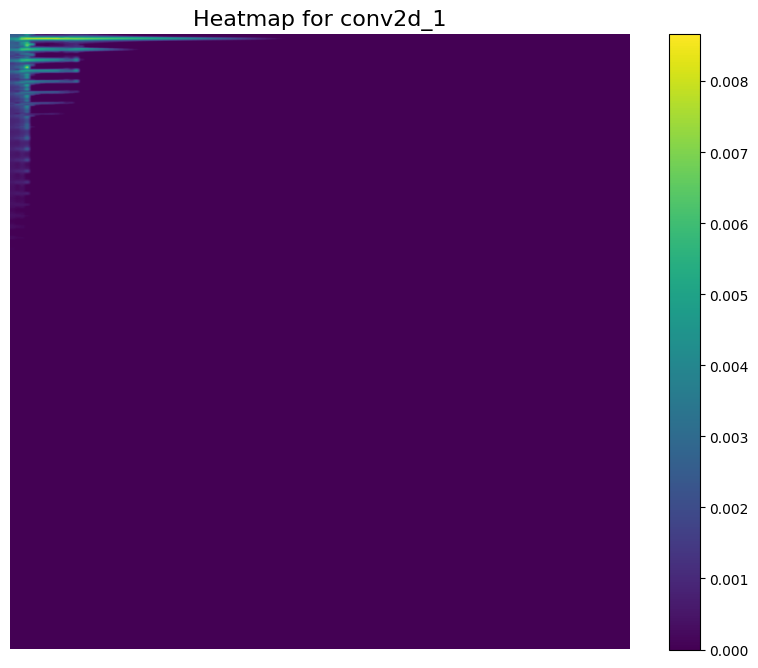

In [15]:
def plot_intermediate_heatmap(model, x_data, layer_name, sample_index=0):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    with tf.GradientTape() as tape:
        inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
        tape.watch(inputs)
        intermediate_output = intermediate_layer_model(inputs)
        predicted_class = tf.argmax(model(inputs)[0])

    grads = tape.gradient(intermediate_output, inputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, intermediate_output), axis=-1).numpy()

    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap[0], aspect='auto', cmap='viridis')
    plt.title(f'Heatmap for {layer_name}', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Example usage:
plot_intermediate_heatmap(loaded_model, x_data, intermediate_heatmap_layer, sample_index=sample_index)


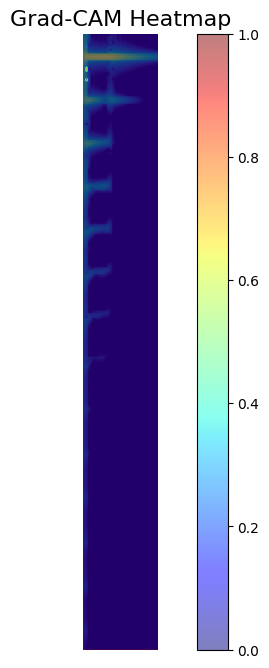

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

def plot_grad_cam(heatmap, img):
    plt.figure(figsize=(10, 8))
    plt.imshow(img, aspect='auto', cmap='viridis')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM Heatmap', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

img_array = np.expand_dims(x_data[sample_index], axis=0)
heatmap = grad_cam(loaded_model, img_array, 'conv2d_5')
plot_grad_cam(heatmap, x_data[sample_index])


Inputs shape: (1, 1025, 126)
Predictions: [[0.20120098]]
Predicted Class: 0
Target Class Output: [0.20120098]
Gradients shape: (1, 1025, 126)
Saliency shape: (1025, 126)


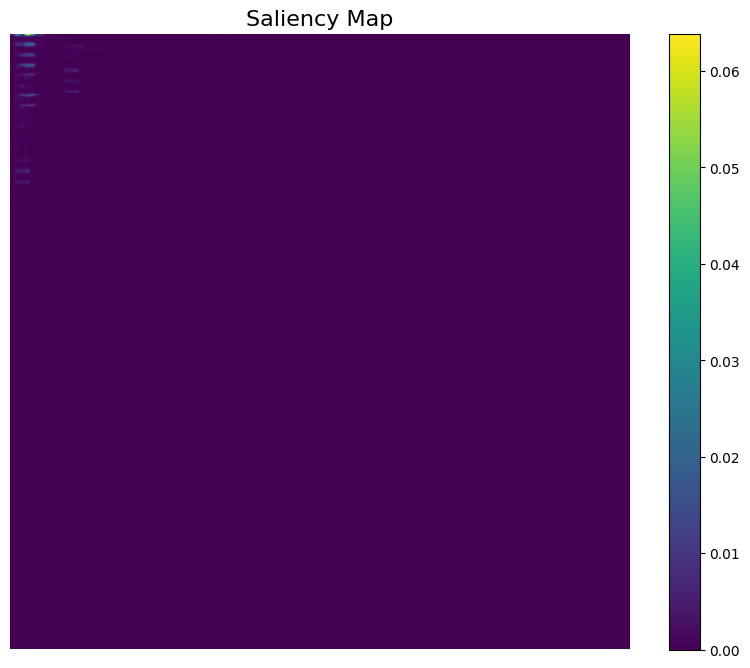

In [38]:
def plot_saliency_map(model, x_data, sample_index=0):
    # Ensure the inputs are correctly shaped
    inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
    print(f"Inputs shape: {inputs.shape}")

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        predicted_class = tf.argmax(predictions[0])
        print(f"Predictions: {predictions}")
        print(f"Predicted Class: {predicted_class}")
        target_class_output = predictions[:, predicted_class]
        print(f"Target Class Output: {target_class_output}")

    grads = tape.gradient(target_class_output, inputs)

    if grads is None:
        print("Gradients are None")
        return

    # Ensure gradients have the correct shape
    print(f"Gradients shape: {grads.shape}")

    # Compute saliency map with the same shape as the input
    saliency = tf.reduce_max(tf.abs(grads), axis=0).numpy()
    print(f"Saliency shape: {saliency.shape}")

    plt.figure(figsize=(10, 8))
    plt.imshow(saliency, aspect='auto', cmap='viridis')
    plt.title('Saliency Map', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Example usage:
plot_saliency_map(loaded_model, x_data, sample_index=sample_index)


Inputs shape: (1, 1025, 126)
Predictions: [[0.20120098]]
Predicted Class: 0
Target Class Output: [0.20120098]
Gradients shape: (1, 1025, 126)
Heatmap shape: (1025, 126)


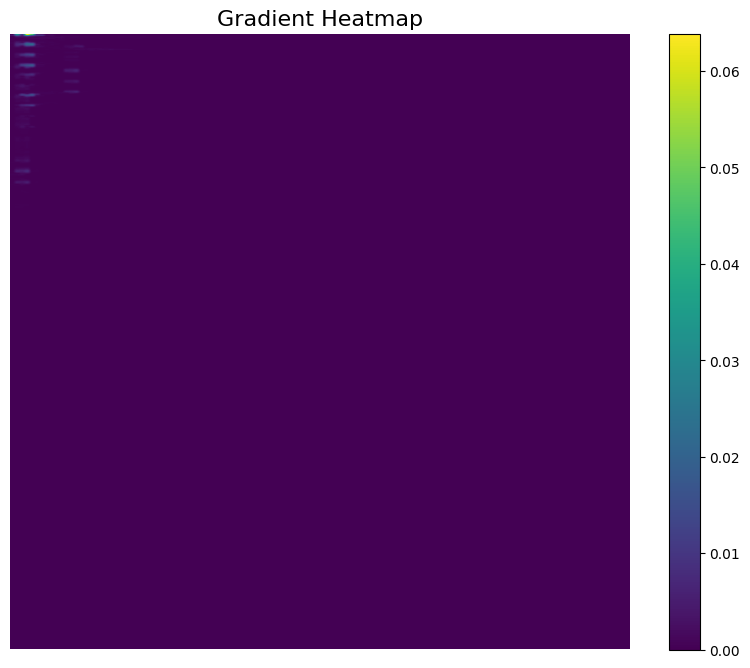

In [40]:
def plot_gradient_heatmap(model, x_data, sample_index=0):
    # Ensure the inputs are correctly shaped
    inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
    print(f"Inputs shape: {inputs.shape}")

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        predicted_class = tf.argmax(predictions[0])
        print(f"Predictions: {predictions}")
        print(f"Predicted Class: {predicted_class}")
        target_class_output = predictions[:, predicted_class]
        print(f"Target Class Output: {target_class_output}")

    grads = tape.gradient(target_class_output, inputs)

    if grads is None:
        print("Gradients are None")
        return

    # Ensure gradients have the correct shape
    print(f"Gradients shape: {grads.shape}")

    # Compute heatmap with the same shape as the input
    heatmap = tf.reduce_max(tf.abs(grads), axis=0).numpy()
    print(f"Heatmap shape: {heatmap.shape}")

    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, aspect='auto', cmap='viridis')
    plt.title('Gradient Heatmap', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Example usage:
plot_gradient_heatmap(loaded_model, x_data, sample_index=sample_index)


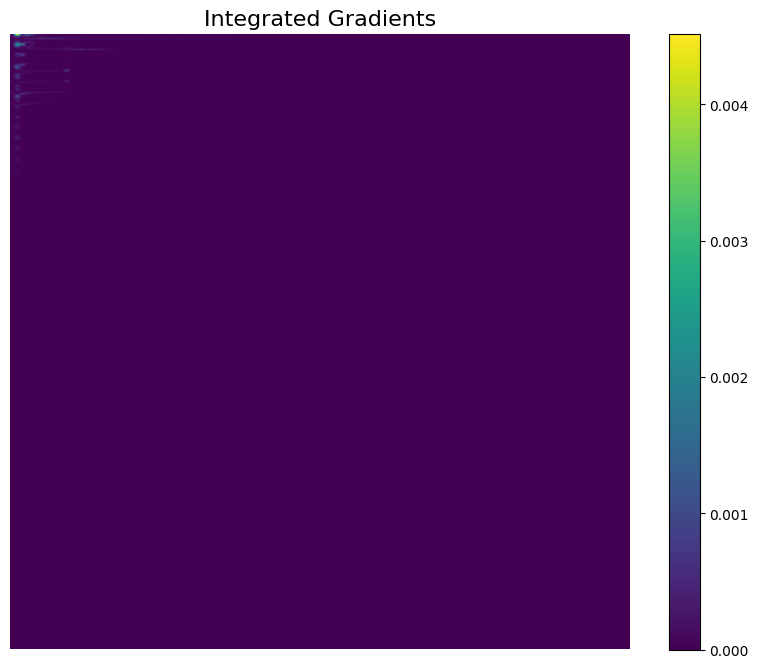

In [33]:
def integrated_gradients(inputs, model, target_class_index, baseline=None, num_steps=50):
    if baseline is None:
        baseline = tf.zeros_like(inputs)

    inputs = tf.cast(inputs, tf.float32)
    baseline = tf.cast(baseline, tf.float32)
    scaled_inputs = [baseline + (float(i) / num_steps) * (inputs - baseline) for i in range(num_steps + 1)]

    grads = []
    with tf.GradientTape(persistent=True) as tape:
        for inp in scaled_inputs:
            tape.watch(inp)
            predictions = model(inp)
            target_predictions = predictions[:, target_class_index]
            grads.append(tape.gradient(target_predictions, inp))

    grads = tf.convert_to_tensor(grads)

    if any(g is None for g in grads):
        print("Some gradients are None")
        return None

    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grad = (inputs - baseline) * avg_grads
    return integrated_grad

def plot_integrated_gradients(model, x_data, sample_index=0, baseline=None, num_steps=50):
    inputs = tf.cast(np.expand_dims(x_data[sample_index], axis=0), tf.float32)
    predictions = model(inputs)
    predicted_class = tf.argmax(predictions[0])

    integrated_grad = integrated_gradients(inputs, model, predicted_class, baseline, num_steps)

    if integrated_grad is None:
        print("Integrated gradients computation failed")
        return

    integrated_grad = integrated_grad.numpy()[0]

    plt.figure(figsize=(10, 8))
    plt.imshow(np.abs(integrated_grad), aspect='auto', cmap='viridis')
    plt.title('Integrated Gradients', fontsize=16)
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Example usage:
plot_integrated_gradients(loaded_model, x_data, sample_index=sample_index)
